<hr>
<h1><b>Coursework 2:</b></h1>
<h3><i>Submitted for the partial fulfilment of the DSM020 course</i></h3>
<h3><i>By Hendrik Matthys van Rooyen</i></h3>
<h3><i>230221176</i></h3>

<hr>

# **Parallel Corpus Sentiment Induction and Sentiment Analysis**

<hr>

## Introduction

In Coursework 1: "Sentiment Induction using the Bible as a Parallel Corpus", it was proposed that a the bible can be used as a Parallel Corpus source to transfer sentiment ratings between languages.
This was shown to be successful from the display of differentiable wordclouds of positive and negative words.

In Coursework 1, some improvements were proposed, including:
- Using a larger primary and secondary corpus for the initial lexicon generation
- Trimming the 0 scoring verses from the primary corpus

Many other improvements were also made, including:
- The automatic download and extraction of the corpora
- The trimming of possible (calculated) stopwords from the lexicon

These improvements are made in this coursework.

In addition Coursework 2 attempts to integrate the sentiment lexicon resulting from Coursework 1 into a sentiment analysis pipeline, which can be used to evaluate the sentiment text of the requested language.
In this case, comments extracted from the popular Afrikaans news website "Maroela Media".
This is done in attempt to demonstrate the feasibility of utilizing "Parallel Corpus Sentiment Induction" in a production environment for a language without a decent sentiment lexicon.

<b>Purpose:</b> To implement a sentiment analysis pipeline capable of providing sentiment scores for the Afrikaans news website "Maroela Media".

**Key Objectives:**
- Implementing and improving the Lexicon generation pipeline from Coursework 1
- Fetch comments from the Wordpress API of "Maroela Media"
- Rate the sentiment of comments
- Generate a report on the sentiment scores, including:
    - Correlations of sentiment scores between the article texts and the comments
    - The change of sentiment scores over time
- Implement unit tests for the pipeline
- Implement logging of the pipeline actions and errors

<hr>

## Prepare Environment

### Load Packages

In [1]:
# Reading from the configuration file
import configparser

# Unit testing
import unittest
from unittest.mock import patch, mock_open, MagicMock

# Logger
import logging
import json
from datetime import datetime
import platform
import inspect

#Read/Write Data
import os
from zipfile import ZipFile
import sqlite3
import sqlalchemy
from sqlalchemy import create_engine, select, update
from sqlalchemy.dialects.sqlite import insert

#Data Processing/Analysis
import pandas as pd
import numpy as np
from statistics import mean
import re
import string
import html
from itertools import groupby

#Graphing
import pandas as pd
import matplotlib.pyplot as plt

#Data Retrieval
import requests

#NLP
from nltk.stem import PorterStemmer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

#Miscellaneous
from datetime import datetime, timedelta
import math
import time

#### Reading from the Configuration File
**Libraries Used:**
- configparser

**Alternatives:**
- json
- yaml
- os.environ

**Reasoning:**

`configparser` was chosen for its ease of use and the ability to include comments in the configuration file, which helps in annotating settings. While JSON and YAML provide more structured data formats, configparser wins for its simplicity and being part of Python's standard library.

#### Unit Testing
**Libraries Used:**
- unittest

***Alternatives:***
- pytest
- nose

**Reasoning:**

`unittest` offers a robust, well documented, and familiar built-in framework for unit testing. While `pytest` might have more features, unittest was chosen for its simplicity and no additional dependencies.

#### Logger

**Libraries Used:**
- logging

**Alternatives:**
- loguru
- sentry

**Reasoning:**

`logging` is Python’s built-in logging framework, making it a reliable choice that doesn't require external dependencies. While alternatives like `sentry` offer more advanced features, `logging` was selected for its simplicity and native support.

#### Reading and Writing Data

**Libraries Used:**
- os
- zipfile
- sqlite3
- sqlalchemy

**Alternatives:**
- shutil
- gzip
- PostgreSQL
- MySQL

**Reasoning:**

These libraries are part of Python's standard libraries, offering native support without extra dependencies. While `PostgreSQL` and `MySQL` provide more features, `sqlite3` and `sqlalchemy` were chosen for their simplicity, ease of use, and that SQLite does not require additional software, or hosting.
SqlAlchemy, being a go to ORM for python was used to demonstrate some of the features of SqlAlchemy and the support the creation of the database.

#### Data Processing and Analysis
**Libraries Used:**
- pandas
- numpy

**Alternatives:**
- dask
- scipy

**Reasoning:**

`pandas` and `numpy` are well-supported and widely used for data manipulation and mathematical operations. `dask` and `scipy` offer extended functionalities but at the cost of added complexity. For simplicity, pandas and numpy were chosen.
As this project has not been developed for the purpose of using extremely large data sets, it will also not be able to fully utilize some of the bennefits provided by `dask`.

#### Graphing
**Libraries Used:**
- matplotlib

**Alternatives:**
- seaborn
- plotly

**Reasoning:**

matplotlib was chosen for its robust and basic graphing capabilities and integration. While seaborn and plotly have aesthetically pleasing graphing options, matplotlib was selected for its simplicity.

#### Natural Language Processing (NLP)
**Libraries Used:**
- nltk.stem
- vaderSentiment

**Alternatives:**
- spaCy
- TextBlob

**Reasoning:**

nltk and vaderSentiment were chosen for their specialized focus on stemming and sentiment analysis. While spaCy and TextBlob offer more comprehensive NLP functionalities, the chosen libraries offer simplicity and are more lightweight, and vaderSentiment specifically provides the ability to rate sentiment on a positive-negative scale.

#### Miscellaneous
**Libraries Used:**
- datetime
- timedelta
- math
- time

**Alternatives:**
- arrow
- dateutil

**Reasoning:**

These libraries are part of Python’s standard library, providing native and simple support for date, time, and mathematical functions. While arrow and dateutil offer extended functionalities, the chosen libraries are simpler and have no additional dependencies.

### Setup Config Reader

To improve usability of the program, a config file 

The config reader has been setup to improve the usability of the `config.ini` file.

It allows for the retrieving of configuration values from the file using a simple structure:

`config['section']['variable']`

This implementation also converts the variables to the appropriate types.

In [2]:
class ConfigReader:
    def __init__(self, config_file_path):
        self.config = configparser.ConfigParser()
        self.config.read(config_file_path)

    #Get section and return he section to be used in the second [...]
    def __getitem__(self, section):
        if(self.config.has_section(section)):
            return ConfigSection(self.config[section])
        
        return ConfigSection(self.config['DEFAULT'])

class ConfigSection:
    def __init__(self, section):
        self.section = section

    #Get the specified variable value for the selected section
    def __getitem__(self, key):
        value = str(self.section.get(key, ''))
        
        #Value type conversion
        if(value == ''): return None
        if(value.isdigit()): return int(value)
        if(value.isdecimal()): return float(value)
        if(value.lower() == 'true' or value.lower() == 'false'): return value.lower() == 'true'
        
        return value

In [3]:
config = ConfigReader('config.ini')

### Setup Logger

Using the `logger` library opposed to create every functionality from scratch allows for easier and a more consistent implementation of logging.

The logger has been set up, drawing much inspiration from ideal messages as would be expected in AWS Cloudwatch logs (JSON Structures).

For now the error messages are logged to the `.log` files, which can considered a local 'Cloudwatch' for the purpose of this assignment.Less detailed error messages are also setup to be printed, alongside messages of other log levels.

Some libraries such as `requests` and `sqlalchemy` have their own implementation of the `logger` library on INFO and DEBUG levels, which interferes with this implementation, so have been set to only log higher levels.

In [4]:
class JsonLogFormatter(logging.Formatter):
    __capture_platform = False
    __json_indent = False
    def __init__(self, capture_platform = False, json_indent = 0):
        self.__capture_platform = capture_platform
        self.__json_indent = json_indent
        super().__init__()
        
    def format(self, record):
        logPayload = {
            'timestamp': str(datetime.fromtimestamp(record.created)),
            'level' : record.levelname,
            'message' : record.msg,
            # used for tracing the call
            'position' : f'{record.module}:{record.funcName}:{record.lineno}',
        }
        
        if (record.exc_info != None): logPayload['exception'] = self.formatException(record.exc_info)
        # custom `model` object to log extra fields or an object as needed
        if (hasattr(record, 'model')): logPayload['model'] = record.model
        # captures details about the system running the code
        if (self.__capture_platform): logPayload['platform'] = platform.uname()
        
        return json.dumps(logPayload,indent= (4) if self.__json_indent else None)

class LineLogFormatter(logging.Formatter):
    def __init__(self):
        super().__init__()
        
    def format(self, record):
        # time and level
        log_string = f"{str(datetime.fromtimestamp(record.created))} [{record.levelname}]:"
        # Indenting of console log based on level of function
        if (config['Logging']['IndentSpaceByStack'] > 0):
            log_string += '\t' + ' ' * (
                config['Logging']['IndentSpaceByStack'] * (sum(1 for frame in inspect.stack() if "\\ipykernel_" in frame.filename) - 4)
                )
        log_string += record.msg
        # exception message
        if (record.exc_info != None): log_string += f" | {record.exc_info[1]}"
        # exception function and line number
        if (record.exc_info != None): log_string += f" | {record.funcName}:{record.lineno}"
        # custom `model` object to log extra fields or an object as needed
        if (hasattr(record, 'model')): log_string += f" | {record.model}"
        
        return log_string

Logger = logging.getLogger()
Logger.handlers = []
Logger.setLevel(logging.DEBUG)    

# create console handler and set level to debug
log_level = (config['Logging']['ConsoleLogLevel'] or 'NONE').upper()
if (log_level in ['ERROR', 'WARN', 'INFO', 'DEBUG','CRITICAL']):
    consoleHandler = logging.StreamHandler()
    consoleHandler.setLevel(log_level)
    consoleHandler.setFormatter(LineLogFormatter())
    Logger.addHandler(consoleHandler)

# create file handler
log_level = (config['Logging']['FileLogLevel'] or 'NONE').upper()
if (log_level in ['ERROR', 'WARN', 'INFO', 'DEBUG','CRITICAL']):
    if not os.path.exists(config['Logging']['FileLogFolder']):
        os.makedirs(config['Logging']['FileLogFolder'])
    
    fileHandler = logging.FileHandler(fr"{config['Logging']['FileLogFolder']}\{datetime.now().date()}.log")
    fileHandler.setLevel(log_level)
    fileHandler.setFormatter(JsonLogFormatter(capture_platform = True))
    Logger.addHandler(fileHandler)
    
# disable debug logs of the libraries that have their own logging implementation
logging.getLogger("requests").setLevel(logging.WARNING)
logging.getLogger("urllib3").setLevel(logging.WARNING)
logging.getLogger("matplotlib").setLevel(logging.WARNING)
logging.getLogger('sqlalchemy').setLevel(logging.ERROR)

### Define Classes

#### `bible`

In [5]:
class Bible:
    ConnectionPath: str
    Corpus: str
    Name: str
    Source: str
    NameShorthand: str
    
    def __init__(self, connectionPath, corpus, source, name, nameShorthand =""):
        self.ConnectionPath = connectionPath
        self.Corpus = corpus
        self.Name = name
        self.Source = source
        self.NameShorthand = nameShorthand

### Setup SQLAlchemy
For the project, it was decided to implement SQLAlchemy as ORM, and connection provider.
This was done to ease and support the development process, automate database creation, and to showcase some more advanced Software Development.

The SQLAlchemy implementation has been through multiple iterations, both to standardize naming and to add more fields to tables.

Best practice would be to implement end enforce foreign key constraints, but that would add additional complexity to the already complex project.

`Comment` Table:
- Contains information regarding the comments left on a post, and has a many-to-one relationship with the `Post` table.

`Post` Table:	
- Contains information regarding the post
- Has a one-to-many relationship with the `Comment` table
- Has a many-to-many relationship with the `Category` table
- Has a many-to-many relationship with the `Tag` table

In [6]:
from sqlalchemy import create_engine, ForeignKey
from sqlalchemy import Column, DateTime, Integer, String
from sqlalchemy.orm import declarative_base

engine = create_engine(config["Database"]["WordPressSync"], echo=False)
Base = declarative_base()

class WP_Comment(Base):
    __tablename__ = "Comment"
    
    comment_id = Column(Integer, primary_key=True)
    post_id = Column(Integer)
    date = Column(sqlalchemy.DATETIME) 
    content = Column(String)
    clean_content = Column(String)
    score = Column(sqlalchemy.Float)

class WP_Post(Base):
    __tablename__ = "Post"
    
    post_id = Column(Integer, primary_key=True)
    link = Column(String)
    date = Column(sqlalchemy.DATETIME)
    modified = Column(sqlalchemy.DATETIME)
    author = Column(Integer)
    title = Column(String)
    title_clean = Column(String)
    title_score = Column(sqlalchemy.Float)
    content = Column(String)
    content_clean = Column(String)
    content_score = Column(sqlalchemy.Float)

class WP_PostCategory(Base):
    __tablename__ = "PostCategory"
    
    post_id = Column(Integer, primary_key=True)
    category_id = Column(Integer, primary_key=True)

class WP_PostTag(Base):
    __tablename__ = "PostTag"
    
    post_id = Column(Integer, primary_key=True)
    tag_id = Column(Integer, primary_key=True)

class WP_Category(Base):
    __tablename__ = "Category"
    
    category_id = Column(Integer, primary_key=True)
    name = Column(String)
    link = Column(String)
    parent_id = Column(Integer)

class WP_Tag(Base):
    __tablename__ = "Tag"
    
    tag_id = Column(Integer, primary_key=True)
    name = Column(String)
    link = Column(String)

Base.metadata.create_all(engine)

###  Set Constants

The Vader sentiment analyzer is set to `const_sia_obj` to be used in scoring the primary corpus in `scorePrimaryCorpus()`.

In [7]:
const_sia_obj = SentimentIntensityAnalyzer()

### Clean Data - Helper Function

This function removes unwanted characters and words from the provided text.

Cleaning text is required in multiple places, and the function is therefore made to cater for all those possibilities.

In [8]:
def clean_text(
    text,
    stopwords = [],
    remove_markup = False,
    remove_bracketed = False,
    remove_punctuation = False,
    remove_special_characters = False, 
    replace_dashes = False
    ):
    
    #remove html
    if remove_markup:
        text = html.unescape(text)
        text = re.sub('<[^<]+?>', '', text)
        text = text.strip()
        text = text.replace("\n"," ")
    
    #remove text within brackets eg. [2], as well as the brackets. Mostly used to denote sub text links.
    if remove_bracketed:
        text = re.sub(r'\[.*?\]', '', text)
    
    #replaces the three types of dashes encountered in the data sources
    if replace_dashes or remove_punctuation:
        text = text.replace('-',' ')
        text = text.replace('–',' ')
        text = text.replace('—',' ')
        
    #remove strange characters
    if remove_special_characters:
        text = "".join([char for char in text if ord(char) < 128])
    
    #this is different from the remove_special_characters as this keeps non-ascii
    if remove_punctuation:
        text = "".join([i for i in text if (i not in string.punctuation and i not in ['…','“','”','‘','’'])])
    
    #removes words if contained in the provided list
    if (len(stopwords) > 0):
        text = " ".join([w for w in text.split(' ') if w.lower() not in stopwords])

    #removes consecutive empty spaces.
    text = re.sub(' +', ' ', text)

    return text

<hr>

## Load or generate the Sentiment Lexicon

### Read list of bible corpora

Function to read and map list of `bible` details from the specified csv file.

The csv file can be specified in the `config.ini`, as LexiconGeneration -> CorpusDetailsFileName

In [9]:
def get_corpus_list():
    return np.array(
        list(map(
            lambda bible_details: 
                Bible(
                    connectionPath=bible_details[0],
                    corpus=bible_details[1],
                    source=bible_details[2],
                    name=bible_details[3],
                    nameShorthand=bible_details[4]
                    ),
                pd.read_csv(config["LexiconGeneration"]["CorpusDetailsFileName"]).values.tolist()
            ))
        )

### Download Corpora

Function to download the bible corpora from a list of `bible`s, they are downloaded as zip files to the specified folder, and then extract them to a different specified file.

- If the directories does not exist, they are created.
- If the zip files do not exist, they are downloaded.
- If the bibles have been downloaded but not extracted, they are extracted.

This function is executed and the returned list is used in the `generateSentimentLexicon()` function, as part of the retrieving and scoring of the primary corpus, as well as the ultimate transfer of the scores to the secondary corpus.

The function currently only caters for the corpus being downloaded from https://www.ph4.org/ which is zip files containing SQLite databases in a specific file structure.

In [10]:
def download_corpus(bibles: list[Bible], zip_download_path = 'zipped', extracted_path = 'corpus'):
    Logger.debug('Start - download_corpus()')
    try:
        #Download missing corpus files
        if not os.path.exists(zip_download_path):
            os.makedirs(zip_download_path)

        zippedFiles = os.listdir(zip_download_path)

        # Loop through the bibles to check if their corresponding zip files exist
        for bible in filter(lambda x: f"{x.NameShorthand}.zip" not in zippedFiles, bibles):
            Logger.info(f"Downloading: {bible.NameShorthand}.zip")
            response = requests.get(bible.Source)
            with  open(f"{zip_download_path}/{bible.NameShorthand}.zip", "wb") as file:
                file.write(response.content)
                file.close()
        
        #Extract un-extracted files    
        if not os.path.exists(extracted_path):
            os.makedirs(extracted_path)
            Logger.info(f"Created: {extracted_path}")
        
        # Group the bibles by their corpus and process them
        for corpusGroup in groupby(bibles, lambda x: x.Corpus):
            corpusFolderName = f"{extracted_path}/{corpusGroup[0]}"
            if not os.path.exists(corpusFolderName):
                os.makedirs(corpusFolderName)
                Logger.info(f"Created: {corpusFolderName}")
            
            corpusFiles = os.listdir(extracted_path)
        
        # Loop through each bible and extract its SQLite3 file if it doesn't already exist
        for bible in bibles:
            path = f"{extracted_path}/{bible.Corpus}"
            if not os.path.exists(f"{extracted_path}/{bible.Corpus}/{bible.NameShorthand}.SQLite3"):
                with ZipFile(f"{zip_download_path}/{bible.NameShorthand}.zip", 'r') as zObject:
                    Logger.info(f"Extracting: {bible.NameShorthand}.SQLite3")
                    zObject.extract(f"{bible.NameShorthand}.SQLite3",path=path)
    except:
        Logger.error("Could not download the corpora", exc_info=True)
    finally:
        Logger.debug('Start - download_corpus()')

### Read Corpora

Function to read bible verses using a list of bibles, these bibles will have to be downloaded prior to reading using the `downloadCorpus()` function.

As mentioned above, the project is currently reliant on a specific structure of the corpus, which is shared, however, in the future this could be expanded to cater for multiple sources of data.

In [11]:
def read_corpus(bibles: list[Bible], corpus_folder = "corpus"):
    corpus = pd.DataFrame()
    for bible in bibles:
        filePath = f"{corpus_folder}/{bible.Corpus}/{bible.NameShorthand}.SQLite3"
        
        con = sqlite3.connect(filePath)
        df = pd.read_sql_query('SELECT * FROM verses', con)
        con.close()
        
        #To keep track of the corpus version for debug purposes
        df["bible_version"] = bible.Name

        corpus = pd.concat([corpus, df], ignore_index=True)
    
    return corpus

### Score Sentiment

A simple function that receives text and uses the Vader sentiment analyzer to determine the sentiment score, which is then returned.

This is vectorized to speed up execution. In the case of Coursework 1, the `swifter` library was used, but after careful evaluation and experimentation vectorization proved to have higher performance. As well as out preforming scoring without either the `swifter` library or vectorization.

In [12]:
def score_sentiment(text):
    if text is None or text.strip() == "":
        return 0.0
    
    sentiment_dict = const_sia_obj.polarity_scores(text)
    
    return sentiment_dict['compound']

### Score Primary Corpus

This function's purpose is to compute the sentiment scores for the primary corpus.

- The function starts by checking if the scores have been computed already
- If it has, then check it is required to recompute the scores
- if either the scores have not been computed or it should be recomputed, then continue to compute, otherwise return the previously computed scores.
- To compute new scores the primary corpus is read by the `readCorpus()` function.
- The dirty text is cleaned by the `cleanText()` function
- The `score_sentiment()` function is vectorized and ran on the text of the corpus
- The 0.00 scored entries are removed from the data set.
    - This is done to polarize the results of the scoring, which in turn will result in a wider range of scores in the secondary corpus and finally the sentiment lexicon.
- The average scores of parallel entries are computed.
- And finally the scores for the primary corpus are saved, read and returned.

In [13]:
def score_primary_corpus(corpus_list, primary_corpus_group, corpus_path, score_database, recalculate = True):
    Logger.debug('Start - score_primary_corpus()')
    try:
        verse_scores = pd.DataFrame()
        
        #connect to the provided database or create a new one
        con = sqlite3.connect(score_database)
        
        #get the amount of database entries
        verse_scores_count = pd.read_sql_query('SELECT count(*) FROM score', con)['count(*)'][0]
        
        Logger.debug(f'Primary corpus verse scores found: [{verse_scores_count}]')
        
        #check if the scores should be recalculated, if no entries were found then also recalculate
        if (recalculate or verse_scores_count == 0) :
            Logger.info('Recalculating primary corpus sentiment scores')
            #read and clean the corpus
            data_frame_primary = read_corpus(filter(lambda x: f"{x.Corpus}" == primary_corpus_group, corpus_list), corpus_path)
            data_frame_primary["text"] = data_frame_primary["text"].apply(lambda x: clean_text(
                x,
                remove_markup = True,
                remove_bracketed = True
                ))
            
            Logger.debug('Start scoring of text')
            #score the text using a vectorized `score_sentiment`
            vectorized_score_sentiment = np.vectorize(score_sentiment)
            data_frame_primary[['compound']] = pd.DataFrame(vectorized_score_sentiment(data_frame_primary["text"]))
            Logger.debug('End scoring of text')
            
            Logger.debug('Remove 0.00 score verses')
            #remove entries from the primary corpus if the score is 0.00
            data_frame_primary = data_frame_primary[data_frame_primary['compound'] != 0.00]
            
            #average out the scores for the parallel entries
            verse_scores = data_frame_primary.groupby(['book_number','chapter','verse']).agg(
                compound = pd.NamedAgg(column="compound", aggfunc = 'mean')
                ).reset_index()
            
            #save to database
            verse_scores.to_sql('score',con,if_exists='replace')
            Logger.info('Saved verse scores to database')
            
        verse_scores = pd.read_sql_query('SELECT * FROM score', con)
        
        con.close()
        return verse_scores
    except:
        Logger.error("Could not score the primary corpus", exc_info=True)
        return None
    finally:
        Logger.debug("End - score_primary_corpus()")

### Generate Sentiment Lexicon

This function, although heavily modified is inspired by the work done in the preceding Coursework 1,

There has been many iterations of this function over the course of the project to include features like:
- the cleaning of text
- triggering of the corpus downloads
- lexicon trimming to remove words with low occurrences
- lexicon trimming to remove words only occurring with capital first letters
- lexicon trimming to remove words with very high occurrences, later removed in favor of generating a list of stopwords.
- generating a list of stopwords based on the occurrence frequency combined with the word score.
    - if a word has a high occurrence but low polarity it is more likely to be a stopword
    - occurences*(1/absolute score)

In [14]:
def generate_sentiment_lexicon(
    primary_corpus_group: str,
    secondary_corpus_group: str,
    download_path,
    extracted_path,
    score_database,
    recalculate_primary_corpus_scores: bool,
    generation_minimum_word_occurrence = 5,
    stopword_count = 250,
    remove_stopwords = True,
    ):
    Logger.debug("Start - generate_sentiment_lexicon()")
    try:
        # Load and download the corpus
        corpus_list = get_corpus_list()
        download_corpus(corpus_list, download_path, extracted_path)
        
        # Score the primary corpus
        verse_scores = score_primary_corpus(corpus_list, primary_corpus_group, extracted_path,score_database, recalculate_primary_corpus_scores)
        
        # Read and clean the secondary corpus
        data_frame_secondary = read_corpus(filter(lambda x: f"{x.Corpus}" == secondary_corpus_group, corpus_list))
        data_frame_secondary["text"] = data_frame_secondary["text"].apply(lambda x: clean_text(
            x,
            remove_markup = True,
            remove_bracketed = True,
            replace_dashes = True,
            remove_punctuation = True
            ))

        # Merge the primary corpus scores into the secondary, this is the core of sentiment induction
        data_frame_secondary = pd.merge(
            data_frame_secondary,
            verse_scores[['book_number','chapter','verse','compound']],
            how='inner',
            on=['book_number','chapter','verse'])
        
        # Split the text into words
        data_frame_secondary["words"] = data_frame_secondary["text"].str.split(" ")
        
        # Expand words into instances of their own, group the entries by word to get average score
        word_score = data_frame_secondary.explode("words")
        word_score = word_score[word_score["words"].notnull()]
        word_score["words_lower"] = word_score["words"].str.lower()
        word_score = word_score.groupby('words_lower').agg(
            compound = pd.NamedAgg(column="compound", aggfunc = "mean"),
            occurrences = pd.NamedAgg(column="words", aggfunc = "count"),
            word_variance = pd.NamedAgg(column="words", aggfunc = (lambda x: sorted(pd.Series.unique(x),reverse=True))),
        )
        word_score['word'] = word_score['word_variance'].str[0]
        
        Logger.debug(f'Lexicon size before trimming: [{len(word_score)}]')
        
        # Remove words that does not occur enough
        word_score = word_score[(word_score['occurrences'] >= generation_minimum_word_occurrence)]
        
        # Determine the likeliness of a given word being a stopword. With the likeliness being determined by the frequency times the inverse of the score
        # Words with more occurrences and a lower score would be considered more likely to be a stopword.
        word_score['stopword_factor'] = word_score['occurrences']*(1/(word_score['compound'].abs()))
        word_score = word_score.sort_values(by='stopword_factor',ascending=False)
        
        word_lexicon = word_score[['word','compound']]
        Logger.debug(f'Lexicon size after trimming low frequency words: [{len(word_lexicon)}]')
        
        # Remove proper nouns
        word_lexicon = word_lexicon[word_lexicon['word'].str[0].str.isupper() == False][['word','compound']]
        Logger.debug(f'Lexicon size after trimming possible Proper nouns: [{len(word_lexicon)}]')
        
        possible_stopwords = word_lexicon['word'].head(stopword_count).tolist()
        
        if (remove_stopwords):
            word_lexicon = word_lexicon.iloc[stopword_count:]
            Logger.debug(f'Lexicon size after removing stopwords: [{len(word_lexicon)}]')
        
        word_lexicon = word_lexicon.set_index('word').sort_values(by='compound')
        
        Logger.info("Lexicon file generated successfully")
        
        return (word_lexicon,possible_stopwords)
    except:
        Logger.error("Could not generate sentiment lexicon", exc_info=True)
        raise
    finally:
        Logger.debug("End - generate_sentiment_lexicon()")

### Primary Function

- Function begins with logging its initiation and initializes a flag for lexicon regeneration to `False`.
- Evaluates conditions to determine whether lexicon regeneration is required or not.
    - These conditions could include explicit instruction, absence of the lexicon file, or an empty lexicon.
- If lexicon regeneration is needed:
    - Validates the presence of essential input variables.
    - Calls a separate function to generate the lexicon and a list of potential stopwords.
    - Saves the newly generated lexicon and list of stopwords to their respective files.
- If lexicon regeneration is not needed, reads the existing lexicon and list of stopwords from pre-specified files.
- Logs details about the number of lexicon entries and marks the end of function execution.
- Returns the lexicon and the list of stopwords.
- If an exception occurs, logs an error and returns a `None` value.

In [15]:
def load_sentiment_lexicon(
    lexicon_file_name: str,
    score_database: str,
    primary_corpus_group,
    secondary_corpus_group,
    always_regenerate = False,
    generation_minimum_word_occurrence = 5,
    download_path = 'download',
    extracted_path = 'corpus',
    recalculate_primary_corpus_scores = False,
    stopword_count = 250
    ):
    Logger.debug("Start - load_sentiment_lexicon()")
    try:
        regenerate_lexicon = False

        if(always_regenerate):
            regenerate_lexicon = True
            
        elif(not os.path.isfile(lexicon_file_name)):
            Logger.info("Lexicon file not found")
            regenerate_lexicon = True
        
        elif(len(pd.read_csv(lexicon_file_name)) <= 1):
            Logger.info("Lexicon is empty")
            regenerate_lexicon = True
            
        if(regenerate_lexicon):
            Logger.info("Generating Lexicon")
            if( not download_path or
                not extracted_path):
                raise Exception("The following input variables are also required to generate the lexicon: [download_path, extracted_path]")
            
            (word_lexicon,possible_stopwords) = generate_sentiment_lexicon(
                primary_corpus_group,
                secondary_corpus_group,
                download_path = download_path,
                extracted_path = extracted_path,
                score_database= score_database,
                recalculate_primary_corpus_scores = recalculate_primary_corpus_scores,
                generation_minimum_word_occurrence = generation_minimum_word_occurrence,
                stopword_count = stopword_count
                )
        
            word_lexicon.to_csv(lexicon_file_name)
            open('stopwords.txt', 'w', encoding='utf-8').write('\n'.join(possible_stopwords))
        
        word_lexicon = pd.read_csv(lexicon_file_name)
        possible_stopwords = open('stopwords.txt', 'r',encoding='utf-8').read().split('\n') if os.path.exists('stopwords.txt') else []
        
        Logger.info("Populated Lexicon file found")
        
        Logger.debug(f'Lexicon entries: {len(word_lexicon)}')
        
        return (word_lexicon, possible_stopwords)
    except:
        Logger.error("Could not load sentiment lexicon", exc_info=True)
        return None
    finally:
        Logger.debug("End - load_sentiment_lexicon()")
        

---

## Load or Sync the WordPress data

The goal of this section of the project is to provide functions able to sync data of a WordPress website incrementally.

The incremental sync hinges on two types of state checks:
- Last updated date checks for the Posts and Comments
- Checking for missing entries, is implemented in the Category and Tag entities.

Categories and Tags, having a many-to-many relationship withe Posts, will first have their IDs synced into the intermediary tables, `PostCategories` and `PostTags`.
Then referencing those, checking which IDs exits in the intermediary tables but not in the full entity table.

The wordpress API allows for public access, negating the need for front-end crawling, and allowing bulk, and specific calls to be made.
- For the Posts and Comments, the API can be called, passing a date filter as parameter.
- For Tags and Categories, the API can be called, passing in specific ID's that should be retrieved

A challenge with passing the ID's is that the WordPress API has a limitation in the in-ability to comprehend long URLs of requests. This prevents the calling of all Tags or Categories by their IDs at once and paging through them all.
To handle this, the ID lists also need to be split into batches of smaller chunks.

For all the sync, a "ping" to the server is made first, primarily to retrieve the list length (the "x-wp-total" header) to setup the paging for requests. It also checks that the site is live before attempting any further calls.

These syncs can be run independently, while if Posts have not been synced, the Category and Tag syncs will not have any effect.

### Comments

#### Get last comment date

In [16]:
def get_last_comment_date():
    last_comment_date = 0
    with engine.connect() as conn:
        
        last_comment_date = conn.execute(
            select(WP_Comment.date).order_by(sqlalchemy.desc(WP_Comment.date)).limit(1)
            ).first()
        
        if (last_comment_date == None) : last_comment_date = (datetime.utcnow() - timedelta(weeks=52)).isoformat()
        else: last_comment_date = last_comment_date[0].isoformat()
        
        conn.close()
    
    return last_comment_date

#### Download new comments from WordPress 

In [17]:
def download_new_word_press_comments(base_url: str, request_page_size = 100 , after_date = None):
    Logger.debug("Start - download_new_word_press_comments()")
    
    responseJson = []
    
    try:
        requestUrl = f'{base_url}/wp-json/wp/v2/comments'
        
        last_comment = get_last_comment_date()
        
        if (after_date == None): after_date = last_comment
        elif(datetime.fromisoformat(after_date) < datetime.fromisoformat(last_comment)): after_date = last_comment
        
        Logger.info(f'Latest comment created at [{last_comment}]')
        
        #ping url
        ping = requests.get(f'{requestUrl}?per_page=1&after={after_date}')
        
        header_total = ping.headers.get('x-wp-total')
        if (header_total == None or header_total == '0'):
            Logger.info(f'No new comments to download')
            return []
            
        count = int(header_total)
        
        pages = math.ceil(count/request_page_size)
        page = 1
        
        Logger.info(f'New comments to download: [{count}]')
        while (page <= pages):
            time.sleep(0.5)
            Logger.debug(f"Getting Comments - Page [{page}/{pages}]")
            requestUrl = f'{base_url}/wp-json/wp/v2/comments'
            requestUrl += f'?per_page={request_page_size}&page={page}&orderby=date&order=asc'
            requestUrl += f'&after={after_date}'
            
            response = requests.get(requestUrl)
            responseJson += response.json()
            
            page += 1
    except:
        Logger.error("Could not load sentiment lexicon", exc_info=True)
    finally:
        Logger.debug("End - download_new_word_press_comments()")
        return responseJson

#### Save comments to the database

In [18]:
def save_comments(comments_json):
    Logger.debug("Start - save_comments()")
    
    if(len(comments_json) < 1):
        Logger.debug("No comments found to save to databases")
        return
    
    comments = list(map(
        lambda x: {
        'comment_id': x['id'],
        'post_id': x['post'],
        'date': datetime.fromisoformat(x['date']),
        'content': x['content']['rendered']
        }, comments_json))
    
    with engine.connect() as conn:

        query = insert(WP_Comment).values(
            comments
        )
    
        query = query.on_conflict_do_update(
            index_elements=['comment_id'],
            set_=dict(query.excluded),
            )
        
        conn.execute(query)
        conn.commit()
        
        conn.close()
        
    Logger.info(f'New comments saved to database')
    
    Logger.debug("End - save_comments()")

#### Load comments from database

In [19]:
def load_comments_from_database(to_clean = False, to_rate = False):
    Logger.debug("Start - load_comments_from_database()")
    
    comments = []
    with engine.connect() as conn:
        statement = (select(WP_Comment).order_by(sqlalchemy.desc(WP_Comment.date)))
        if (to_clean): statement = statement.where(sqlalchemy.or_(
            WP_Comment.clean_content == None,
            WP_Comment.clean_content == ''))
        
        if (to_rate): statement = statement.where(sqlalchemy.or_(
            WP_Comment.score == None,
            WP_Comment.score == ''))
        
        comments = conn.execute(
            statement
            ).all()
        
        conn.close()
        
    Logger.debug("End - load_comments_from_database()")
    
    return pd.DataFrame(comments)

### Posts (News Articles)

#### Get last post date

In [20]:
def get_last_post_date():
    last_post_date = 0
    with engine.connect() as conn:
        
        last_post_date = conn.execute(select(WP_Post.date).order_by(sqlalchemy.desc(WP_Post.date)).limit(1)).first()
        
        if (last_post_date == None) : last_post_date = (datetime.utcnow() - timedelta(weeks=52)).isoformat()
        else: last_post_date = last_post_date[0].isoformat()
        
        conn.close()
    
    return last_post_date

#### Download new posts from WordPress

In [21]:
def download_new_word_press_posts(base_url: str, request_page_size = 100, after_date = None):
    Logger.debug("Start - download_new_word_press_posts()")
    
    requestUrl = f'{base_url}/wp-json/wp/v2/posts'
    last_post = get_last_post_date()
    
    if (after_date == None): after_date = last_post
    elif(datetime.fromisoformat(after_date) < datetime.fromisoformat(last_post)): after_date = last_post
    
    Logger.info(f'Latest post created at [{last_post}]')
    
    #ping url
    ping = requests.get(f'{requestUrl}?per_page=1&after={after_date}')
    
    header_total = ping.headers.get('x-wp-total')
    if (header_total == None or header_total == '0'):
        Logger.info(f'No new posts to download')
        Logger.debug("End - download_new_word_press_posts()")
        return []
        
    count = int(header_total)
    pages = math.ceil(count/request_page_size)
    page = 1
    
    Logger.info(f'New posts to download: [{count}]')
    
    responseJson = []
    while (page <= pages):
        time.sleep(0.5)
        Logger.debug(f"Getting Posts - Page [{page}/{pages}]")
        requestUrl = f'{base_url}/wp-json/wp/v2/posts'
        requestUrl += f'?per_page={request_page_size}&page={page}&orderby=date&order=asc'
        requestUrl += f'&after={after_date}'
        
        response = requests.get(requestUrl)
        responseJson += response.json()
        
        page += 1
    
    Logger.debug("End - download_new_word_press_posts()")
    return responseJson

#### Save posts to database

One of the major decision influencers of this function was the initial sync of posts, which poses a challenge as there is a limit to the number of variables that can be provided in an INSERT statement in SQLite.

In [22]:
def save_posts(posts_json):
    Logger.debug("Start - save_posts()")
    try:
    
        if(len(posts_json) < 1):
            Logger.debug("No posts found to save to databases")
            return
        
        posts = list(map(
            lambda post: {
            'post_id': post['id'],
            'link': post['link'],
            'date': datetime.fromisoformat(post['date']),
            'modified': datetime.fromisoformat(post['modified']),
            'author': post['author'],
            'title': post['title']['rendered'],
            'content': post['content']['rendered'],
            }, posts_json))
        
        with engine.connect() as conn:
            query = insert(WP_Post).values(
                posts
            )
        
            query = query.on_conflict_do_update(
                index_elements=['post_id'],
                set_=dict(query.excluded),
                )
            
            conn.execute(query.execution_options(insertmanyvalues_page_size=50))
            conn.commit()
            
            conn.close()
            
        Logger.info(f'New posts saved to database')
    except:
        Logger.error("Could not save posts", exc_info=True)
    finally:
        Logger.debug("End - save_posts()")

In [23]:
def save_post_categories(posts_json):
    Logger.debug("Start - save_post_categories()")
    
    if(len(posts_json) < 1):
        Logger.debug("No posts found to save to databases")
        return

    split_categories = lambda post: [{'post_id': post['id'], 'category_id': category_id} for category_id in post['categories']]

    # Use the map function to split categories and flatten the result
    mapped_list = list(map(split_categories, posts_json))
    mapped_list = [obj for sublist in mapped_list for obj in sublist]
    
    with engine.connect() as conn:

        query = insert(WP_PostCategory).values(
            mapped_list
        )
    
        query = query.on_conflict_do_nothing(
            index_elements=['post_id', 'category_id'],
            )
        
        conn.execute(query)
        conn.commit()
        
        conn.close()
        
    Logger.info(f'New post categories saved to database')
    
    Logger.debug("End - save_post_categories()")

In [24]:
def save_post_tags(posts_json):
    Logger.debug("Start - save_post_tags()")
    
    if(len(posts_json) < 1):
        Logger.debug("No posts found to save to databases")
        return

    split_tags = lambda post: [{'post_id': post['id'], 'tag_id': tag_id} for tag_id in post['tags']]

    # Use the map function to split categories and flatten the result
    mapped_list = list(map(split_tags, posts_json))
    mapped_list = [obj for sublist in mapped_list for obj in sublist]
    
    with engine.connect() as conn:

        query = insert(WP_PostTag).values(
            mapped_list
        )
    
        query = query.on_conflict_do_nothing(
            index_elements=['post_id', 'tag_id'],
            )
        
        conn.execute(query)
        conn.commit()
        
        conn.close()
        
    Logger.info(f'New post tags saved to database')
    
    Logger.debug("End - save_post_tags()")

#### Load posts from database

In [25]:
def load_posts_from_database(to_clean = False, to_rate = False):
    Logger.debug("Start - load_posts_from_database()")
    
    posts = []
    with engine.connect() as conn:
        statement = (select(WP_Post).order_by(sqlalchemy.desc(WP_Post.date)))
        if (to_clean): statement = statement.where(sqlalchemy.or_(
            WP_Post.content_clean == None, WP_Post.title_clean == None,
            WP_Post.content_clean == '', WP_Post.title_clean == ''))
        
        if (to_rate): statement = statement.where(sqlalchemy.or_(
            WP_Post.content_score == None, WP_Post.title_score == None,
            WP_Post.content_score == '', WP_Post.title_score == ''))
        
        posts = conn.execute(
            statement
            ).all()
        
        conn.close()
        
    Logger.debug("End - load_posts_from_database()")
    
    return pd.DataFrame(posts)

### Categories

#### Get missing categories

In [26]:
def get_missing_categories():
    categories = []
    with engine.connect() as conn:
        categories = conn.execute(
            select(WP_PostCategory.category_id.distinct())
            .where(WP_PostCategory.category_id.not_in(
                select(WP_Category.category_id)
                ))
            )
        conn.close()
        
    return list(map(lambda entry: str(entry[0]), categories.all()))

#### Download missing categories

In [27]:
def download_missing_categories(base_url: str, request_page_size = 100):
    Logger.debug("Start - download_missing_categories()")
    
    requestUrl = f'{base_url}/wp-json/wp/v2/categories'
    
    missing_categories = get_missing_categories()
    
    if (len(missing_categories) == 0): 
        Logger.info(f'No missing categories')
        Logger.debug("End - download_missing_categories()")
        return []
    
    Logger.info(f'Missing categories: [{len(missing_categories)}]')
    
    missing_categories_string = ','.join(missing_categories)
    
    #ping url
    ping = requests.get(f'{requestUrl}?per_page=1&include={missing_categories_string}')
    
    count = int(ping.headers.get('x-wp-total'))
    pages = math.ceil(count/request_page_size)
    page = 1
    
    Logger.info(f'New categories to download: [{count}]')
    
    responseJson = []
    while (page <= pages):
        time.sleep(0.5)
        Logger.debug(f"Getting Categories - Page [{page}/{pages}]")
        
        requestUrl += f'?per_page={request_page_size}&page={page}'
        requestUrl += f'&include={missing_categories_string}'
        
        response = requests.get(requestUrl)
        responseJson += response.json()
        
        page += 1
    
    Logger.debug("End - download_missing_categories()")
    return responseJson

#### Save Categories

In [28]:
def save_categories(posts_json):
    Logger.debug("Start - save_categories()")
    
    if(len(posts_json) < 1):
        Logger.debug("No categories found to save to database")
        return
    
    categories = list(map(
        lambda post: {
        'category_id': post['id'],
        'link': post['link'],
        'name': post['name'],
        'parent_id': post['parent']
        }, posts_json))
    
    with engine.connect() as conn:

        query = insert(WP_Category).values(
            categories
        )
    
        query = query.on_conflict_do_update(
            index_elements=['category_id'],
            set_=dict(query.excluded),
            )
        
        conn.execute(query)
        conn.commit()
        
        conn.close()
        
    Logger.info(f'New categories saved to database')
    
    Logger.debug("End - save_categories()")

### Tags

#### Get missing tags

In [29]:
def get_missing_tags():
    tags = []
    with engine.connect() as conn:
        tags = conn.execute(
            select(WP_PostTag.tag_id.distinct())
            .where(WP_PostTag.tag_id.not_in(
                select(WP_Tag.tag_id)
                ))
            )
        conn.close()
        
    return list(map(lambda entry: str(entry[0]), tags.all()))

#### Download missing tags

In [30]:
def download_missing_tags(base_url: str, request_page_size = 100, batch_size = 50):
    Logger.debug("Start - download_missing_tags()")
    
    responseJson = []
    requestUrl = f'{base_url}/wp-json/wp/v2/tags'
    try:
        
        missing_tags = get_missing_tags()
        missing_tags_count = len(missing_tags)
        if (missing_tags_count == 0): 
            Logger.info(f'No missing tags')
            Logger.debug("End - downloadMissingTags")
            return []
        
        Logger.info(f'Missing tags to download: [{missing_tags_count}]')
        batch_number = 1
        batches = math.ceil(missing_tags_count/batch_size)
        if (batch_size < request_page_size): request_page_size = batch_size
        
        for i in range(0, missing_tags_count, batch_size):
            batch = missing_tags[i:i + batch_size]  
            missing_tags_string = ','.join(batch)
            
            #ping url
            pages = 1
            page = 1
            requestUrl = f'{base_url}/wp-json/wp/v2/tags'
            
            if (batch_size > request_page_size):
                ping = requests.get(f'{requestUrl}?per_page=1&include={missing_tags_string}')
                count = int(ping.headers.get('x-wp-total'))
                pages = math.ceil(count/request_page_size)
            
            while (page <= pages):
                time.sleep(0.5)
                Logger.debug(f"Getting Tags - Batch [{batch_number}/{batches}] - Page [{page}/{pages}]")
                
                requestUrl += f'?per_page={request_page_size}&page={page}'
                requestUrl += f'&include={missing_tags_string}'
                
                response = requests.get(requestUrl)
                responseJson += response.json()
                
                page += 1
            
            batch_number += 1
    except:
        Logger.error("Error while fetching Tags", exc_info=True, model = {requestUrl})
    finally:
        Logger.debug("End - download_missing_tags()")
    
    return responseJson

#### Save Tags

In [31]:
def save_tags(posts_json):
    Logger.debug("Start - save_tags()")
    try:
        if(len(posts_json) < 1):
            Logger.debug("No tags found to save to database")
            return
        
        tags = list(map(
            lambda post: {
            'tag_id': post['id'],
            'name': post['name'],
            'link': post['link']
            }, posts_json))
        
        with engine.connect() as conn:

            query = insert(WP_Tag).values(
                tags
            )
        
            query = query.on_conflict_do_update(
                index_elements=['tag_id'],
                set_=dict(query.excluded),
                )
            
            conn.execute(query)
            conn.commit()
            
            conn.close()
            
    except:
        Logger.error("Could save tags", exc_info=True)
    finally:
        Logger.info(f'New tags saved to database')
    
    Logger.debug("End - save_tags")

### Clean HTML data

For the cleaning of both the Post and Comment data the pattern is followed as:
- Retrieve the data
- Clean
- Map cleaned field(s) and primary key
- Save to database

Cleaning the data can also be run independently of the other syncs

#### Clean Posts

In [32]:
def clean_posts():
    Logger.debug("Start - clean_posts()")
    try:
        posts = load_posts_from_database(to_clean=True)
        
        if (len(posts) == 0):
            Logger.info("No posts found to clean")
            return
        
        posts['title_clean'] = posts['title'].apply(lambda x: 
            clean_text(x, remove_markup = True, remove_bracketed = True, remove_punctuation = True))
        posts['content_clean'] = posts['content'].apply(lambda x: 
            clean_text(x, remove_markup = True, remove_bracketed = True, remove_punctuation = True))
        
        posts = posts[['post_id','title_clean','content_clean']].to_dict(orient='records')
        
        with engine.connect() as conn:
            query = insert(WP_Post).values(
                posts
            )
        
            query = query.on_conflict_do_update(
                index_elements=['post_id'],
                set_=dict(title_clean = query.excluded.title_clean, content_clean = query.excluded.content_clean),
                )
            
            conn.execute(query)
            conn.commit()
            
            conn.close()
    except:
        Logger.error("Could not clean posts", exc_info=True)
    finally:
        Logger.debug("End - clean_posts()")

#### Clean Comments

In [33]:
def clean_comments():
    Logger.debug("Start - clean_comments()")
    try:
        comments = load_comments_from_database(to_clean=True)
        
        if (len(comments) == 0):
            Logger.info("No comments found to clean")
            return
        
        comments['clean_content'] = comments['content'].apply(lambda x: 
            clean_text(x,
            remove_markup = True,
            remove_bracketed = True,
            replace_dashes = True,
            #remove_special_characters = True,
            remove_punctuation = True
            ))
        
        comments = comments[['comment_id','clean_content']].to_dict(orient='records')
        
        with engine.connect() as conn:
            
            if(len(comments) > 0):
                batches = [comments[i:i + 100] for i in range(0, len(comments), 100)]
                for i, batch in enumerate(batches):
                    query = insert(WP_Comment).values(
                        batch
                    )
                
                    query = query.on_conflict_do_update(
                        index_elements=['comment_id'],
                        set_=dict(clean_content = query.excluded.clean_content),
                        )
                    
                    conn.execute(query)
                    
            conn.commit()
            
            conn.close()
    except:
        Logger.error("Could not clean comments", exc_info=True)
    finally:
        Logger.debug("End - clean_comments()")

### Primary Function
This function triggers the downloading and saving of the data from the specified WordPress website.

The function provides control over which data should be downloaded, this is handy if only a specific subset of the data needs to be updated. This is also handy to test specific functionality.

Batch processing has been implemented specifically to handle large initial data downloads. It was implemented after trying to download a year's worth of data, at which point SQLite was no longer capable to handle the amount of data.

After the initial data download all downloads are run incrementally, building on previous downloads.

In [34]:
def update_word_press_data(
    base_url: str,
    download_posts: bool = True,
    download_comments: bool = True,
    download_categories: bool = True,
    download_tags: bool = True,
    request_page_size = 100,
    download_start_date_time = None,
    clean_html_data: bool = True,
    batch_insert_size = 100
    ):
    try:
        Logger.debug("Start - update_word_press_data()")
        
        if(download_posts):
            Logger.info("Downloading WordPress Post data")
            json_list = download_new_word_press_posts(base_url, request_page_size, download_start_date_time)
            if(len(json_list) > 0):
                batches = [json_list[i:i + batch_insert_size] for i in range(0, len(json_list), batch_insert_size)]
                for i, batch in enumerate(batches):
                    save_posts(batch)
                    save_post_categories(batch)
                    save_post_tags(batch)
        
        if(download_categories):
            Logger.info("Downloading WordPress Category data")
            json_list = download_missing_categories(base_url, request_page_size)
            if(len(json_list) > 0):
                batches = [json_list[i:i + batch_insert_size] for i in range(0, len(json_list), batch_insert_size)]
                for i, batch in enumerate(batches):
                    save_categories(batch)
        
        if(download_tags):
            Logger.info("Downloading WordPress Tag data")
            json_list = download_missing_tags(base_url, request_page_size)
            if(len(json_list) > 0):
                batches = [json_list[i:i + batch_insert_size] for i in range(0, len(json_list), batch_insert_size)]
                for i, batch in enumerate(batches):
                    save_tags(batch)
        
        if(download_comments):
            Logger.info("Downloading WordPress Comments data")
            json_list = download_new_word_press_comments(base_url, request_page_size, download_start_date_time)
            if(len(json_list) > 0):
                batches = [json_list[i:i + batch_insert_size] for i in range(0, len(json_list), batch_insert_size)]
                for i, batch in enumerate(batches):
                    save_comments(batch)
        
        if(clean_html_data):
            Logger.info("Cleaning HTML data")
            clean_posts()
            clean_comments()
        
    except:
        Logger.error("Could not load the wordpress data", exc_info=True)
        return (None, None)
    finally:
        Logger.debug("End - update_word_press_data()")

---

## Sentiment Scoring

This section of sentiment scoring works differently than that of scoring the primary corpus, used in the lexicon generation.

In determining the optimal method of scoring the wordpress text, using the average score of each word provided the best (most reliable and polarized) results, while not having a unrealistic execution time.
Replacing the built in lexicon of the Vader `SentimentIntensityAnalyzer` with the one generated was attempted, but this did not generate satisfactory results.

In calculating the average score, using the levenshtein distance to determine related words as well as a regex search try and cater for prefixes and suffixes was also attempted, however this was also not satisfactory, as it regularly misidentified words.

It was decided that a simple stemmer from the `ntlk` library would be used to cater for suffixes, however in most cases the word to be scored would simply be looked up in the lexicon.

There was also experimented with the normalization of the scores in attempt to polarize the results more, but this resulted in the scores, in stead of converging at just above 0, having unpredictable distribution, with the content score clustering at maximum.

### Calculate Sentiment

In [35]:
def calculate_custom_sentiment(text: str, lexicon: dict, stopwords:list[str] = [], normalize = False):
    sentiment_sum = 0.0
    word_count = 0
    stemmer = PorterStemmer()

    for word in text.lower().split():
        if stopwords is not None and word in stopwords:
            continue
        stemmed_word = stemmer.stem(word)
        if stemmed_word in lexicon:
            sentiment_sum += lexicon[stemmed_word]
            word_count += 1
        elif word in lexicon:
            sentiment_sum += lexicon[word]
            word_count += 1

    if word_count == 0:
        return 0.0
    if normalize:
        return math.tanh(sentiment_sum)
    
    return sentiment_sum / word_count

In [36]:
def levenshtein_distance(s1, s2):
    if len(s1) > len(s2):
        s1, s2 = s2, s1
    distances = range(len(s1) + 1)
    for i2, c2 in enumerate(s2):
        distances_ = [i2 + 1]
        for i1, c1 in enumerate(s1):
            if c1 == c2:
                distances_.append(distances[i1])
            else:
                distances_.append(1 + min((distances[i1], distances[i1 + 1], distances_[-1])))
        distances = distances_
    return distances[-1]


def calculate_custom_sentiment_levenshtein(text: str, lexicon: dict, normalize = False):
    sentiment_sum = 0.0
    word_count = 0

    for word in text.lower().split():
        found = False
        if word in lexicon:
            sentiment_sum += lexicon[word]
            word_count += 1
            found = True
        else:
            for lex_word in lexicon.keys():
                if re.search(lex_word[:4], word) or levenshtein_distance(lex_word, word) <= 2:
                    sentiment_sum += lexicon[lex_word]
                    word_count += 1
                    found = True
                    break
        if not found:
            pass

    if word_count == 0:
        return 0.0
    if normalize:
        return math.tanh(sentiment_sum)
    
    return sentiment_sum / word_count

In [37]:
def update_comment_sentiments(lexicon:pd.DataFrame, stopwords:list[str] = [], update_all = False):
    Logger.debug("Start - update_comment_sentiments()")
    try:
        comments = load_comments_from_database(to_rate = not update_all)
        if (len(comments)==0): return 
        lexicon_dict = lexicon.set_index('word').to_dict()['compound']
        
        comments['score'] = comments['clean_content'].apply(lambda x: calculate_custom_sentiment(x, lexicon_dict, stopwords))
        
        comments = comments[['comment_id','score']].to_dict(orient='records')
            
        with engine.connect() as conn:
            if(len(comments) > 0):
                batches = [comments[i:i + 100] for i in range(0, len(comments), 100)]
                for i, batch in enumerate(batches):
                    query = insert(WP_Comment).values(
                        batch
                        )
                    
                    query = query.on_conflict_do_update(
                        index_elements=['comment_id'],
                        set_=dict(score = query.excluded.score),
                        )
                    
                    conn.execute(query)
            conn.commit()
            conn.close()
    except:
        Logger.error("Failed to update comment sentiment scores", exc_info=True)
    finally:
        Logger.debug("End - update_comment_sentiments()")

In [38]:
def update_post_sentiments(lexicon:pd.DataFrame, stopwords:list[str] = [], update_all = False):
    Logger.debug("Start - update_post_sentiments()")
    try:
        posts = load_posts_from_database(to_rate = not update_all)
        if(len(posts) == 0): return 
        lexicon_dict = lexicon.set_index('word').to_dict()['compound']
        
        posts['title_score'] = posts['title_clean'].apply(lambda x: calculate_custom_sentiment(x, lexicon_dict, stopwords))
        posts['content_score'] = posts['content_clean'].apply(lambda x: calculate_custom_sentiment(x, lexicon_dict, stopwords))
        
        posts = posts[['post_id','title_score','content_score']].to_dict(orient='records')
            
        with engine.connect() as conn:
            if(len(posts) > 0):
                batches = [posts[i:i + 100] for i in range(0, len(posts), 100)]
                for i, batch in enumerate(batches):
                    query = insert(WP_Post).values(
                        batch
                        )
                    
                    query = query.on_conflict_do_update(
                        index_elements=['post_id'],
                        set_=dict(title_score = query.excluded.title_score, content_score = query.excluded.content_score),
                        )
                    
                    conn.execute(query)
            
            conn.commit()
            conn.close()
    except:
        Logger.error("Failed to update post sentiment scores", exc_info=True)
    finally:
        Logger.debug("End - update_post_sentiments()")

### Primary Function

In [39]:

def score_word_press_sentiment(lexicon:pd.DataFrame, stopwords:list[str] = [], always_rescore=False):
    Logger.debug("Start - score_word_press_sentiment()")
    try:
        update_comment_sentiments(lexicon,update_all = always_rescore)
        update_post_sentiments(lexicon,update_all = always_rescore)
    except:
        Logger.error("Failed to set wordpress sentiment scores", exc_info=True)
    finally:
        Logger.debug("End - score_word_press_sentiment()")

---

## Setup Unit Tests

The unit tests have been implemented to firstly showcase test driven development, as in the case of the `TestCleanText` test case, as well as demonstrating the use of mocking libraries to run more complex tests, as in the case of `TestLexiconGeneration` and `TestScoreSentiment`

### Clean Text

In [40]:
class TestCleanText(unittest.TestCase):
    
    @classmethod
    def setUpClass(cls):
        Logger.debug('Unit Tests Started - TestCleanText')

    def test_remove_markup(self):
        self.assertEqual(clean_text("<p>Hello</p>", remove_markup=True), "Hello")

    def test_remove_bracketed(self):
        self.assertEqual(clean_text("This is [useless] text.", remove_bracketed=True), "This is text.")

    def test_replace_dashes(self):
        self.assertEqual(clean_text("This is - a test.", replace_dashes=True), "This is a test.")

    def test_remove_special_characters(self):
        self.assertEqual(clean_text("This is a “test”", remove_special_characters=True), "This is a test")

    def test_remove_punctuation(self):
        self.assertEqual(clean_text("Hello, world!", remove_punctuation=True), "Hello world")

    def test_remove_stopwords(self):
        self.assertEqual(clean_text("This is a test", stopwords=["this", "is"], remove_punctuation=True), "a test")

    def test_multiple_options(self):
        self.assertEqual(
            clean_text("<p>This is [not] a “test”.</p>",
                    remove_markup=True,
                    remove_bracketed=True,
                    remove_special_characters=True,
                    remove_punctuation = True),
                "This is a test")

    def test_no_options(self):
        self.assertEqual(clean_text("This is a test"), "This is a test")

    def test_empty_string(self):
        self.assertEqual(clean_text(""), "")
    
    @classmethod
    def tearDownClass(cls):
        cls.corpusList = None
        Logger.debug('Unit Tests Ended - TestCleanText')

### Lexicon Generation

In [41]:
class TestLexiconGeneration(unittest.TestCase):
    
    @classmethod
    def setUpClass(cls):
        Logger.debug('Unit Tests Started - TestLexiconGeneration')
        cls.corpusList = get_corpus_list()

    def test_any_corpora(self):
        self.assertTrue(TestLexiconGeneration.corpusList.any())

    def test_corpora_of_type_bible(self):
        self.assertTrue(all(isinstance(n, Bible) for n in TestLexiconGeneration.corpusList))
        
    def test_more_than_one_corpora_groups(self):
        self.assertGreaterEqual(len(np.unique(list(map(lambda x: x.Corpus, TestLexiconGeneration.corpusList)))), 2)
    
    @classmethod
    def tearDownClass(cls):
        cls.corpusList = None
        Logger.debug('Unit Tests Ended - TestLexiconGeneration')

### Read Corpus

With fairly limited knowledge this attempts to use the mock functionality of unit testing to specify results to be returned on a call to a library.

In [42]:
class TestReadCorpus(unittest.TestCase):
    
    @classmethod
    def setUpClass(cls):
        Logger.debug('Unit Tests Started - TestReadCorpus')

    @patch('pandas.read_sql_query')
    @patch('sqlite3.connect')
    def test_read_single_corpus(self, mock_sqlite_connect, mock_read_sql_query):
        # Arrange
        mock_read_sql_query.return_value = pd.DataFrame({'col1': [1, 2], 'col2': [3, 4]})
        mock_sqlite_connect.return_value = MagicMock()

        bible_1 = Bible('connectionPath1', 'corpus1', 'source1', 'name1', 'shorthand1')
        bibles = [bible_1]

        # Act
        result = read_corpus(bibles)

        # Assert
        self.assertIsNotNone(result)
        self.assertTrue('bible_version' in result.columns)
        self.assertEqual(len(result), 2)
        self.assertEqual(result['bible_version'][0], 'name1')
    
    @patch('pandas.read_sql_query')
    @patch('sqlite3.connect')
    def test_read_multiple_corpora(self, mock_sqlite_connect, mock_read_sql_query):
        # Arrange
        mock_read_sql_query.return_value = pd.DataFrame({'col1': [1, 2], 'col2': [3, 4]})
        mock_sqlite_connect.return_value = MagicMock()

        bible_1 = Bible('connectionPath1', 'corpus1', 'source1', 'name1', 'shorthand1')
        bible_2 = Bible('connectionPath2', 'corpus2', 'source2', 'name2', 'shorthand2')
        bibles = [bible_1, bible_2]

        # Act
        result = read_corpus(bibles)

        # Assert
        self.assertIsNotNone(result)
        self.assertTrue('bible_version' in result.columns)
        self.assertEqual(len(result), 4)
        self.assertEqual(result['bible_version'][0], 'name1')
        self.assertEqual(result['bible_version'][2], 'name2')
    
    @classmethod
    def tearDownClass(cls):
        cls.corpusList = None
        Logger.debug('Unit Tests Ended - TestReadCorpus')

### Score Sentiment

In [43]:
class TestScoreSentiment(unittest.TestCase):
    
    @classmethod
    def setUpClass(cls):
        Logger.debug('Unit Tests Started - TestScoreSentiment')

    @patch.object(SentimentIntensityAnalyzer, 'polarity_scores')
    def test_positive_sentiment(self, mock_polarity_scores):
        mock_polarity_scores.return_value = {'compound': 0.5}
        
        result = score_sentiment("This is good!")
        
        self.assertEqual(result, 0.5)

    @patch.object(SentimentIntensityAnalyzer, 'polarity_scores')
    def test_negative_sentiment(self, mock_polarity_scores):
        mock_polarity_scores.return_value = {'compound': -0.5}
        
        result = score_sentiment("This is bad!")
        
        self.assertEqual(result, -0.5)

    def test_empty_string(self):
        
        result = score_sentiment("")
        
        self.assertEqual(result, 0.0)

    def test_null_string(self):
        result = score_sentiment(None)
        
        self.assertEqual(result, 0.0)
        
    @classmethod
    def tearDownClass(cls):
        cls.corpusList = None
        Logger.debug('Unit Tests Ended - TestScoreSentiment')

In [44]:
score_sentiment(None)

0.0

<hr>

## Run Pipeline

### 1. Run Unit Tests

In [45]:
if(config['UnitTests']['Enabled']):
    try:
        if (not unittest.main(argv=['ignored', '-v'], exit= False).result.wasSuccessful()):
            raise Exception('Unit test(s) failed')
    except:
        Logger.error("Problem during unit tests", exc_info=True)
        raise

2023-09-17 16:41:59.453601 [DEBUG]:	Unit Tests Started - TestCleanText
test_empty_string (__main__.TestCleanText.test_empty_string) ... ok
test_multiple_options (__main__.TestCleanText.test_multiple_options) ... ok
test_no_options (__main__.TestCleanText.test_no_options) ... ok
test_remove_bracketed (__main__.TestCleanText.test_remove_bracketed) ... ok
test_remove_markup (__main__.TestCleanText.test_remove_markup) ... ok
test_remove_punctuation (__main__.TestCleanText.test_remove_punctuation) ... ok
test_remove_special_characters (__main__.TestCleanText.test_remove_special_characters) ... ok
test_remove_stopwords (__main__.TestCleanText.test_remove_stopwords) ... ok
test_replace_dashes (__main__.TestCleanText.test_replace_dashes) ... ok
2023-09-17 16:41:59.885597 [DEBUG]:	Unit Tests Ended - TestCleanText
2023-09-17 16:41:59.905624 [DEBUG]:	Unit Tests Started - TestLexiconGeneration
test_any_corpora (__main__.TestLexiconGeneration.test_any_corpora) ... ok
test_corpora_of_type_bible (__m

### 2.  Run Lexicon Generation/Loading

In [46]:
(lexicon,stopwords) = load_sentiment_lexicon(
    lexicon_file_name = config['LexiconGeneration']['LexiconFileName'],
    score_database= config["Database"]["Scores"],
    always_regenerate = config['LexiconGeneration']['AlwaysRegenerate'],
    generation_minimum_word_occurrence = config['LexiconGeneration']['MinimumWordOccurrence'],
    primary_corpus_group = config['LexiconGeneration']['PrimaryCorpusGroup'],
    secondary_corpus_group = config['LexiconGeneration']['SecondaryCorpusGroup'],
    download_path = config['LexiconGeneration']['DownloadPath'],
    extracted_path = config['LexiconGeneration']['ExtractedPath'],
    recalculate_primary_corpus_scores = config['LexiconGeneration']['RecalculatePrimaryScore'],
    stopword_count = config['LexiconGeneration']['StopwordCount'],
    )

2023-09-17 16:42:00.052866 [DEBUG]:	Start - load_sentiment_lexicon()
2023-09-17 16:42:00.080903 [INFO]:	Populated Lexicon file found
2023-09-17 16:42:00.105441 [DEBUG]:	Lexicon entries: 4954
2023-09-17 16:42:00.123464 [DEBUG]:	End - load_sentiment_lexicon()


### 3. Sync Wordpress Site

In [47]:
update_word_press_data(
    base_url = config["WordPress"]["BaseURL"],
    download_posts = config["WordPress"]["DownloadPosts"],
    download_comments = config["WordPress"]["DownloadComments"],
    download_categories = config["WordPress"]["DownloadCategories"],
    download_tags = config["WordPress"]["DownloadTags"],
    request_page_size = config["WordPress"]["RequestPageSize"],
    download_start_date_time = config["WordPress"]["DownloadStartDateTime"],
    clean_html_data = config["WordPress"]["CleanHtmlData"]
    )

2023-09-17 16:42:00.147493 [DEBUG]:	Start - update_word_press_data()
2023-09-17 16:42:00.166017 [DEBUG]:	End - update_word_press_data()


### 4. Score Sentiment

In [48]:
score_word_press_sentiment(
    lexicon = lexicon,
    stopwords = stopwords,
    always_rescore = config['WordPress']['AlwaysRescoreSentiment'],
    )

2023-09-17 16:42:00.190354 [DEBUG]:	Start - score_word_press_sentiment()
2023-09-17 16:42:00.208381 [DEBUG]:	    Start - update_comment_sentiments()
2023-09-17 16:42:00.227412 [DEBUG]:	        Start - load_comments_from_database()
2023-09-17 16:42:00.890308 [DEBUG]:	        End - load_comments_from_database()
2023-09-17 16:42:00.913932 [DEBUG]:	    End - update_comment_sentiments()
2023-09-17 16:42:00.932989 [DEBUG]:	    Start - update_post_sentiments()
2023-09-17 16:42:00.953123 [DEBUG]:	        Start - load_posts_from_database()


2023-09-17 16:42:02.797584 [DEBUG]:	        End - load_posts_from_database()
2023-09-17 16:42:02.818606 [DEBUG]:	    End - update_post_sentiments()
2023-09-17 16:42:02.838630 [DEBUG]:	End - score_word_press_sentiment()


---

## Generate Report

For the purpose of the project, in writing the report and generating the accompanying graphs, a focus is placed on two aspects.

Firstly, to discuss and demonstrate the ability of Sentiment Induction in sentiment analysis of lesser known languages.
And secondly, to use the sentiment scoring to make relevant and interesting findings regarding the data.

In demonstrating the ability of Sentiment Induction, the following is used:
- Sentiment by Word Count.
- Sentiment Score distribution.
- Sentiment Score Box-Plots.

Interesting Findings include:
- Investigating the change in sentiment over time.
- Investigating the correlation between the sentiment of comments and that of post titles and content.
- Identifying how sentiment of comments relates to the categories and tags of articles.
- Identifying the most positively and negatively rated articles

### 1. Load Data

In [49]:
def load_post_categories(to_clean = False, to_rate = False):
    Logger.debug("Start - load_post_categories()")
    # Selecting a list of posts with the joined category
    post_categories = []
    with engine.connect() as conn:
        post_categories = conn.execute(
            sqlalchemy.text('SELECT PC.post_id, C.name `category` FROM  PostCategory PC JOIN Category C on PC.category_id = C.category_id')
            ).all()
        
        conn.close()
        
    Logger.debug("End - load_post_categories()")
    
    return pd.DataFrame(post_categories)

In [50]:
def load_post_tags(to_clean = False, to_rate = False):
    Logger.debug("Start - load_post_tags()")
    # Selecting a list of post ids joined with the linked tag
    post_tags = []
    with engine.connect() as conn:
        post_tags = conn.execute(
            sqlalchemy.text('SELECT PT.post_id, T.name `tag` FROM  PostTag PT JOIN Tag T on PT.tag_id = T.tag_id')
            ).all()
        
        conn.close()
        
    Logger.debug("End - load_post_tags()")
    
    return pd.DataFrame(post_tags)

In [51]:
def load_text_length_and_score():
    Logger.debug("Start - load_text_length_and_score()")
    
    comment_scores = []
    title_scores = []
    content_scores = []
    with engine.connect() as conn:
        
        # Gets the length of the text of comments alongside the score
        comment_scores += conn.execute(
            sqlalchemy.text(
                            '''
                            SELECT 
                                score AS score,
                                length(trim(clean_content)) - length(replace(trim(clean_content), ' ', '')) + 1 AS length,
                                'comment' as type
                            FROM comment
                            WHERE score is not NULL
                            ORDER BY score;
                            '''
                            )
            ).all()
        
        # Gets the length of the text of titles alongside the score
        title_scores += conn.execute(
            sqlalchemy.text(
                            '''SELECT 
                                title_score AS score,
                                length(trim(title_clean)) - length(replace(trim(title_clean), ' ', '')) + 1 AS length,
                                'title' as type
                            FROM Post
                            WHERE title_score is not NULL
                            ORDER BY title_score;
                            '''
                            )
            ).all()
        
        # Gets the length of the text of content alongside the score
        content_scores += conn.execute(
            sqlalchemy.text(
                            '''
                            SELECT 
                                content_score AS score,
                                length(trim(content_clean)) - length(replace(trim(content_clean), ' ', '')) + 1 AS length,
                                'content' as type
                            FROM Post
                            WHERE content_score is not NULL
                            ORDER BY content_score;
                            '''
                            )
            ).all()
        
        conn.close()
        
    Logger.debug("End - load_text_length_and_score()")
    
    return (pd.DataFrame(comment_scores),pd.DataFrame(title_scores),pd.DataFrame(content_scores))

In [52]:
def load_comment_sentiment_correlations():
    Logger.debug("Start - load_comment_sentiment_correlations()")
    
    title_correlations = []
    content_correlations = []
    with engine.connect() as conn:
        # Get the score for all titles as well as the average comment score
        title_correlations = conn.execute(
            sqlalchemy.text('''
                            SELECT
                                AVG(C.score) AS comment_score,
                                P.title_score AS title_score
                            FROM post AS P
                            JOIN comment C ON P.post_id = C.post_id
                            GROUP BY P.post_id
                            ''')
            ).all()
        
        # Get the score for all content as well as the average comment score
        content_correlations = conn.execute(
            sqlalchemy.text('''
                            SELECT
                                AVG(C.score) AS comment_score,
                                P.content_score AS content_score
                            FROM post AS P
                            JOIN comment C ON P.post_id = C.post_id
                            GROUP BY P.post_id
                            ''')
            ).all()
        
        conn.close()
        
    Logger.debug("End - load_comment_sentiment_correlations()")
    
    return (pd.DataFrame(title_correlations),pd.DataFrame(content_correlations))

In [53]:
def load_ordered_categories_and_tags():
    Logger.debug("Start - load_ordered_categories_and_tags()")
    
    category_by_comment_score = []
    tag_by_comment_score = []
    category_by_content_score = []
    tag_by_content_score = []
    with engine.connect() as conn:
        
        # Get the get the average comment score by category name
        category_by_comment_score = conn.execute(
            sqlalchemy.text('''
                            SELECT
                                Ca.name AS Category,
                                AVG(C.score) AS Score
                            FROM Comment C
                            JOIN Post P ON P.post_id = C.post_id
                            JOIN PostCategory PC on PC.post_id = P.post_id
                            JOIN Category Ca on Ca.category_id = PC.category_id
                            GROUP BY Ca.name
                            HAVING Count(*) > 5
                            ORDER BY AVG(C.score)
                            ''')
            ).all()
        
        # Get the get the average comment score by tag name
        tag_by_comment_score = conn.execute(
            sqlalchemy.text('''
                            SELECT
                                T.name AS Tag,
                                AVG(C.score) as Score
                            FROM Comment C
                            JOIN Post P ON P.post_id = C.post_id
                            JOIN PostTag PT on PT.post_id = P.post_id
                            JOIN Tag T on T.tag_id = PT.tag_id
                            GROUP BY T.name
                            Having COUNT(*) > 5
                            ORDER BY AVG(C.score)
                            ''')
            ).all()
        
        # Get the get the average content score by category name
        category_by_content_score = conn.execute(
            sqlalchemy.text('''
                            SELECT
                                Ca.name AS Category,
                                AVG(P.content_score) AS Score
                            FROM Post P 
                            JOIN PostCategory PC on PC.post_id = P.post_id
                            JOIN Category Ca on Ca.category_id = PC.category_id
                            GROUP BY Ca.name
                            HAVING COUNT(*) > 5
                            ORDER BY AVG(P.content_score)
                            ''')
            ).all()
        
        # Get the get the average content score by tag name
        tag_by_content_score = conn.execute(
            sqlalchemy.text('''
                            SELECT
                                T.name AS Tag,
                                AVG(P.content_score) AS Score
                            FROM Post P 
                            JOIN PostTag PT on PT.post_id = P.post_id
                            JOIN Tag T on T.tag_id = PT.tag_id
                            GROUP BY T.name
                            HAVING COUNT(*) > 5
                            ORDER BY AVG(P.content_score)
                            ''')
            ).all()
        
        conn.close()
        
    Logger.debug("End - load_ordered_categories_and_tags()")
    
    return (
        pd.DataFrame(category_by_comment_score),
        pd.DataFrame(tag_by_comment_score),
        pd.DataFrame(category_by_content_score),
        pd.DataFrame(tag_by_content_score),
        )

In [54]:
score_lengths = load_text_length_and_score()

2023-09-17 16:42:02.935247 [DEBUG]:	Start - load_text_length_and_score()


2023-09-17 16:42:03.515610 [DEBUG]:	End - load_text_length_and_score()


In [55]:
df_posts = load_posts_from_database()
df_comments = load_comments_from_database()
df_post_categories = load_post_categories()
df_post_tags = load_post_tags()

2023-09-17 16:42:03.571296 [DEBUG]:	Start - load_posts_from_database()


2023-09-17 16:42:04.098549 [DEBUG]:	End - load_posts_from_database()
2023-09-17 16:42:04.140652 [DEBUG]:	Start - load_comments_from_database()
2023-09-17 16:42:04.390553 [DEBUG]:	End - load_comments_from_database()
2023-09-17 16:42:04.477717 [DEBUG]:	Start - load_post_categories()
2023-09-17 16:42:04.511256 [DEBUG]:	End - load_post_categories()
2023-09-17 16:42:04.535795 [DEBUG]:	Start - load_post_tags()
2023-09-17 16:42:04.577004 [DEBUG]:	End - load_post_tags()


### 2. Report and Analysis

#### Ability of Sentiment Induction

2023-09-17 16:42:04.607336 [DEBUG]:	Start - load_text_length_and_score()


2023-09-17 16:42:05.167055 [DEBUG]:	End - load_text_length_and_score()


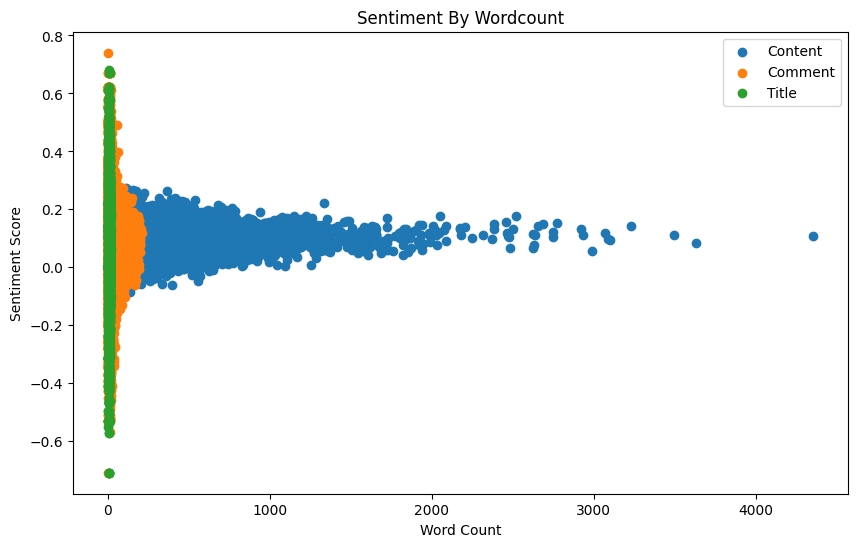

In [56]:
(comment_scores,title_scores,content_scores) = load_text_length_and_score()

plt.figure(figsize=(10, 6))
colors = {'content':'green','title':'red', 'comment':'blue'}
plt.scatter(content_scores['length'],content_scores['score'], label='Content')
plt.scatter(comment_scores['length'],comment_scores['score'], label='Comment')
plt.scatter(title_scores['length'],title_scores['score'], label='Title')
plt.title('Sentiment By Wordcount')
plt.xlabel('Word Count')
plt.ylabel('Sentiment Score')
plt.legend(loc='upper right')
plt.show()

Here we can perceive the variation in the sentiments, and we can see that there is a decent variation.

A prior analysis resulted in the implementation of the `generation_maximum_word_occurrence` variable in the `LoadSentimentLexicon` and in turn the `generateSentimentLexicon`, as before the variation had a strong tendency towards an average as the text to analyze became larger.

This can still be witnessed to a degree, but much less so.

This could also be counteracted by the use of stopwords.

---

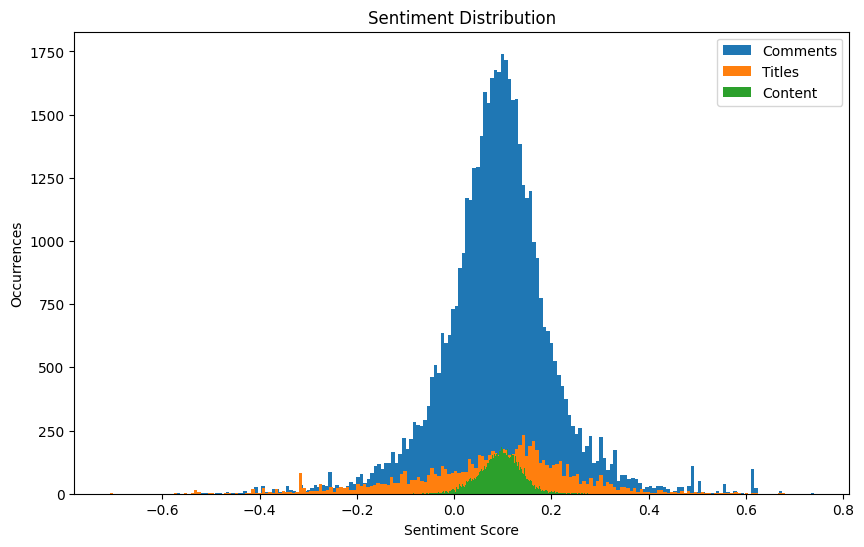

In [57]:
plt.figure(figsize=(10, 6))
colors = {'content':'green','title':'red', 'comment':'blue'}
plt.hist(comment_scores[comment_scores['score'] != 0.00]['score'], bins=200, label='Comments')
plt.hist(title_scores[title_scores['score'] != 0.00]['score'], bins=200, label='Titles')
plt.hist(content_scores[content_scores['score'] != 0.00]['score'], bins=200, label='Content')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment Score')
plt.ylabel('Occurrences')
plt.legend(loc='upper right')
plt.show()

In the graphic we can see that the Comment and Content sentiment has a semi-normal distribution, with both centered and centered slightly more positive.

The titles sentiment has a much wider distribution, but, although not clear from this graph, also centers slightly more positive. See the `Sentiment Box-Plots`

---

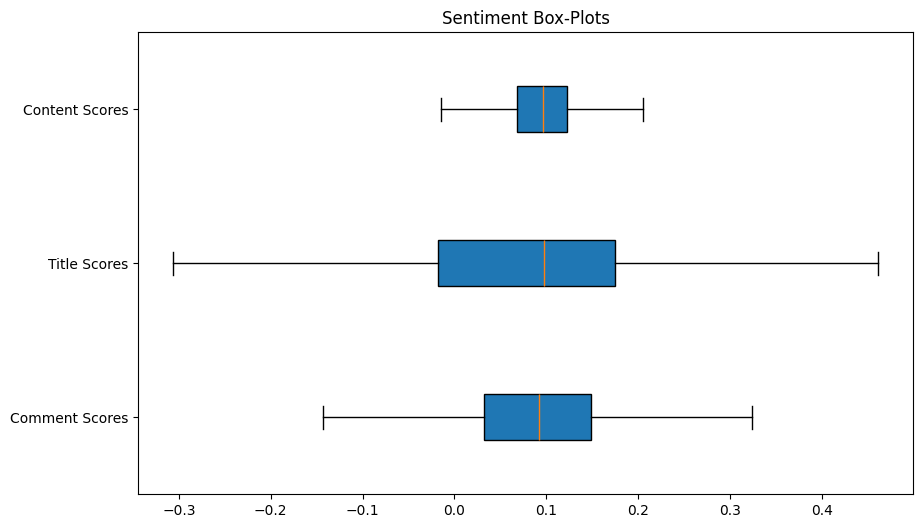

In [58]:
data = [
    comment_scores[comment_scores['score'] != 0.00]['score'],
    title_scores[title_scores['score'] != 0.00]['score'], 
    content_scores[content_scores['score'] != 0.00]['score']]

plt.figure(figsize=(10, 6))
plt.boxplot(data,sym='',patch_artist=True,vert = 0,labels=['Comment Scores','Title Scores','Content Scores'])
plt.title("Sentiment Box-Plots")

plt.show()

This graphic clarifies the distribution of the sentiment scores, displaying the ranges of each text source's sentiment.

As stated before, a likely cause of the narrower distribution of sentiment, is the length of the text, causing the sentiment to tend towards the average for all texts within.

---

#### Investigate Data Attributes

Here the study attempts to investigate the correlation between the sentiment of comments and the title and content of posts/articles.

The change of sentiment over time is also investigated.

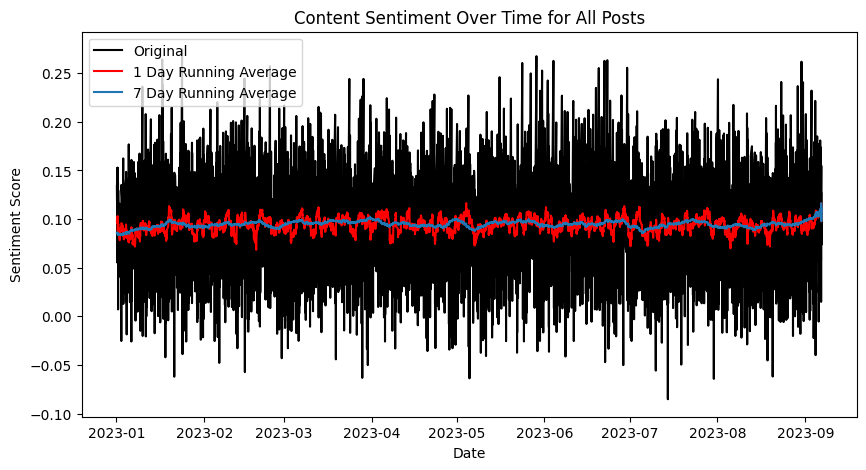

In [59]:
plt.figure(figsize=(10, 5))

plt.title('Content Sentiment Over Time for All Posts')
plt.plot(df_posts.set_index('date')['content_score'], 'k-', label='Original')
plt.plot(df_posts.set_index('date')['content_score'].rolling(window='1D').mean(), 'r-', label='1 Day Running Average')
plt.plot(df_posts.set_index('date')['content_score'].rolling(window='7D').mean(),  label='7 Day Running Average')
plt.ylabel('Sentiment Score')
plt.xlabel('Date')
#plt.fill_between(t_average.index, 0, t_average, color='r', alpha=0.1)
plt.legend(loc='upper left')
plt.show()

Here it can be seen that although the sentiment of the post content is ranging quite a bit day by day, the average sentiment does however hold at about 0.07.

No significant increase or decrease in is noted over time.

---

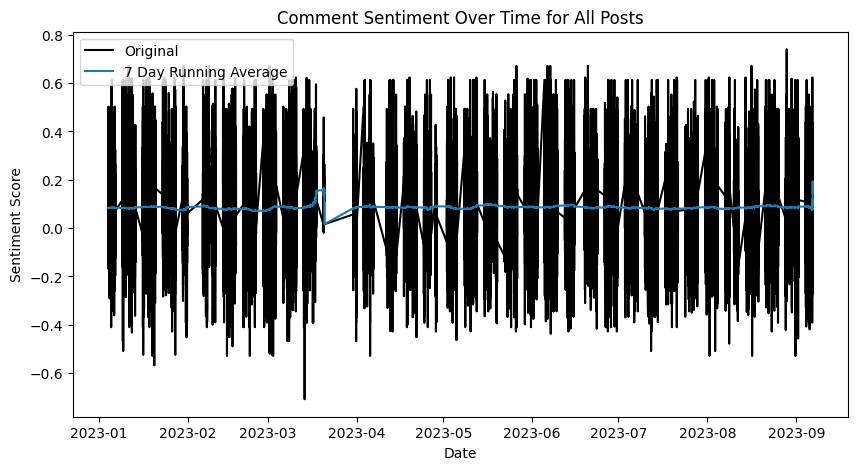

In [60]:
plt.figure(figsize=(10, 5))

plt.title('Comment Sentiment Over Time for All Posts')
plt.plot(df_comments.set_index('date')['score'], 'k-', label='Original')
plt.plot(df_comments.set_index('date')['score'].rolling(window='7D').mean(),  label='7 Day Running Average')
plt.ylabel('Sentiment Score')
plt.xlabel('Date')
#plt.fill_between(t_average.index, 0, t_average, color='r', alpha=0.1)
plt.legend(loc='upper left')
plt.show()

Here it can be seen that although the sentiment of the comment is ranging quite a bit day by day, the average sentiment does however hold at about 0.01 - 0.02.

No significant increase or decrease in is noted over time.

Something interesting to not on the data is the gaps in time, this is because the source website chooses to disable the commenting functionality over weekends, as well as for a week in late March.

---

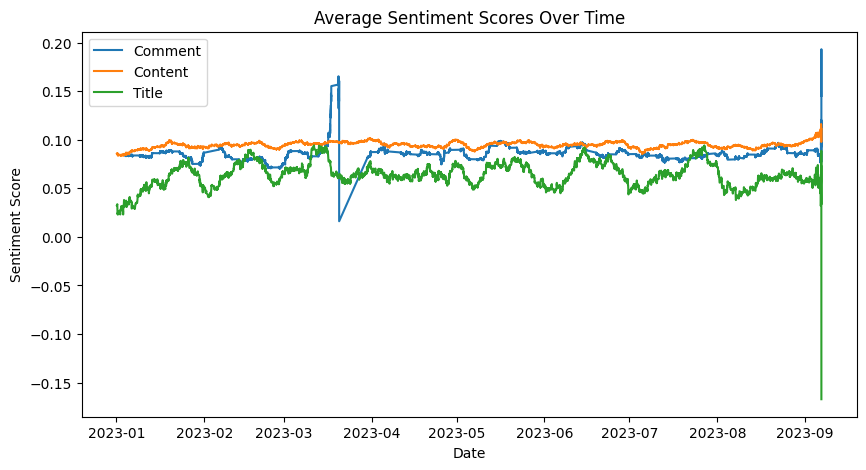

In [61]:
plt.figure(figsize=(10, 5))

plt.title('Average Sentiment Scores Over Time')
plt.plot(df_comments.set_index('date')['score'].rolling(window='7D').mean(), label='Comment')
plt.plot(df_posts.set_index('date')['content_score'].rolling(window='7D').mean(), label='Content')
plt.plot(df_posts.set_index('date')['title_score'].rolling(window='7D').mean(), label='Title')
plt.ylabel('Sentiment Score')
plt.xlabel('Date')
#plt.fill_between(t_average.index, 0, t_average, color='r', alpha=0.1)
plt.legend(loc='upper left')
plt.show()

This graphic shows the Comment and Title falls within the same average range, however the Post Content is constantly scored higher on average.

The Content average being higher can be likely attributed to the length of the text, which will also become clear in the `Sentiment by Wordcount` graphic.

---

2023-09-17 16:42:06.961843 [DEBUG]:	Start - load_comment_sentiment_correlations()


2023-09-17 16:42:07.164548 [DEBUG]:	End - load_comment_sentiment_correlations()


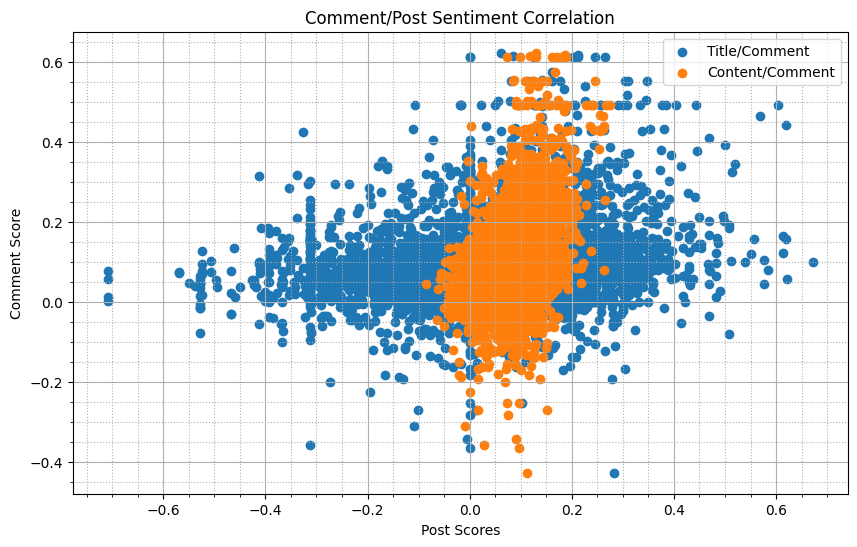

In [62]:
(title_correlations,content_correlations) = load_comment_sentiment_correlations()
plt.figure(figsize=(10, 6))
colors = {'content':'green','title':'red', 'comment':'blue'}
plt.scatter(title_correlations['title_score'],title_correlations['comment_score'], label='Title/Comment')
plt.scatter(content_correlations['content_score'],content_correlations['comment_score'], label='Content/Comment')
plt.title('Comment/Post Sentiment Correlation')
plt.xlabel('Post Scores')
plt.ylabel('Comment Score')
plt.legend(loc='upper right')

plt.grid(which='both')

plt.grid(which='minor', linestyle=':')

plt.minorticks_on()
plt.show()

In [63]:
np.corrcoef(title_correlations['title_score'],title_correlations['comment_score'])

array([[1.        , 0.19179318],
       [0.19179318, 1.        ]])

In [64]:
np.corrcoef(content_correlations['content_score'],content_correlations['comment_score'])

array([[1.        , 0.38235832],
       [0.38235832, 1.        ]])

From the graphic and the correlation matrix, it can be noted that there is not a significant directional correlation between the sentiments.

It can once again be noted how the sentiments tend to be more positive than negative.

This will also be further substantiated by the `Sentiment Distribution` graph.

---

In [65]:
def formatTopBottom(dataFrame:pd.DataFrame, count = 5, top_color='red', bottom_color='green'):
    df_top = dataFrame.head(count).copy()
    df_top['Color'] = top_color
    df_bottom = dataFrame.tail(count).copy()
    df_bottom['Color'] = bottom_color
    return pd.concat([df_top, df_bottom], axis=0).reset_index(drop=True)
    

2023-09-17 16:42:07.530119 [DEBUG]:	Start - load_ordered_categories_and_tags()


2023-09-17 16:42:07.933670 [DEBUG]:	End - load_ordered_categories_and_tags()


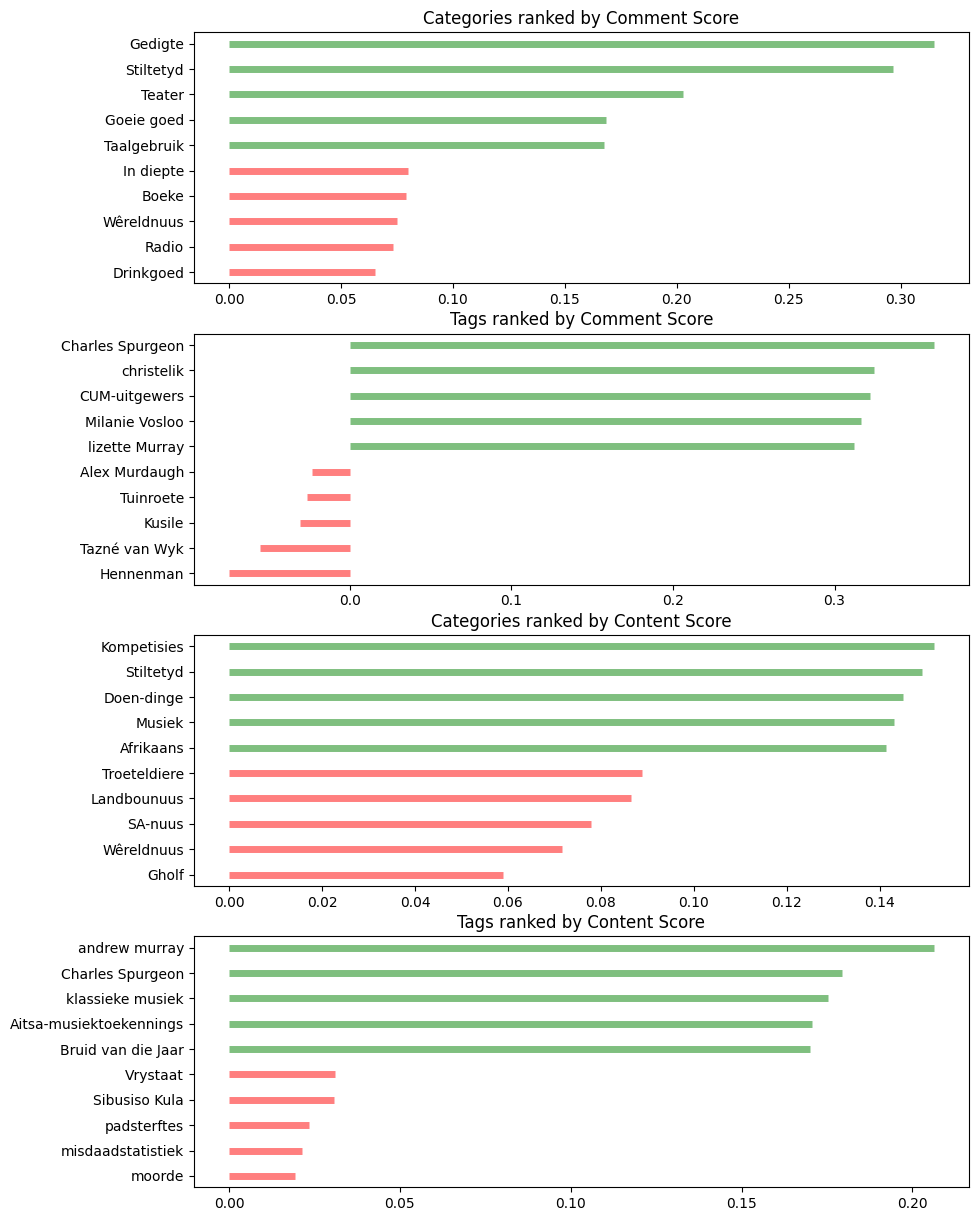

In [66]:
(category_by_comment_score,tag_by_comment_score,category_by_content_score,tag_by_content_score) = load_ordered_categories_and_tags()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(10, 15))

category_by_comment_score = formatTopBottom(category_by_comment_score)
ax1.hlines(y=category_by_comment_score.Category, xmin=0, xmax=category_by_comment_score.Score, alpha=0.5,colors = category_by_comment_score.Color, linewidth=5)
ax1.set_title('Categories ranked by Comment Score')

tag_by_comment_score = formatTopBottom(tag_by_comment_score)
ax2.hlines(y=tag_by_comment_score.Tag, xmin=0, xmax=tag_by_comment_score.Score, alpha=0.5,colors = tag_by_comment_score.Color, linewidth=5)
ax2.set_title('Tags ranked by Comment Score')

category_by_content_score = formatTopBottom(category_by_content_score)
ax3.hlines(y=category_by_content_score.Category, xmin=0, xmax=category_by_content_score.Score, alpha=0.5,colors = category_by_content_score.Color, linewidth=5)
ax3.set_title('Categories ranked by Content Score')

tag_by_content_score = formatTopBottom(tag_by_content_score)
ax4.hlines(y=tag_by_content_score.Tag, xmin=0, xmax=tag_by_content_score.Score, alpha=0.5,colors = tag_by_content_score.Color, linewidth=5)
ax4.set_title('Tags ranked by Content Score')
plt.show()

As the relation to the different tags and categories in the graphs may not make sense to a non-Afrikaans non-South African reader, translations and context is provided below.

##### Categories ranked by Comment Score
Top:
- Gedigte => Poems
- Stiltetyd => Quiet time
- Teater => Theater
- Goeie Goed => Good Things
- Taal Gebruik => Language use

Bottom:
- In Diepte => In depth
- Boeke => Books
- Wêreldnuus => World News
- Radio => Radio
- Drinkgoed => Beverages

##### Tags ranked by Comment Score
Top:
- Charles Spurgeon => 1800s English Particular Baptist preacher, quoted in regular christian thought pieces.
- christelik => christian
- CUM-uitgewers => CUM-publishers, South African Christian Art Distributor and Publisher
- Milanie Vosloo => Business woman, author, columnist, motivational speaker. Her writing is quoted in a similar fashion as Charles Spurgeon.
- lizette Murray => Christian writer, quoted in a similar fashion as Milanie Vosloo and Charles Spurgeon

Bottom:
- Alex Murdaugh => United States lawyer, sentenced to life in prison for the murder of his wife and son.
- Tuinroete => Garden Route, a district municipality in the news for a concerning amount of crime.
- Kusile => Coal Power station plagued by alleged corruption and disruptions in generation.
- Tazné van Wyk => Victim (8 year old) of brutal murder, culprit sentenced to prison in February.
- Hennenman => Town in the Free State goldfields, location of brutal farm murder in which a Father and Son perished.

##### Categories ranked by Content Score
Top:
- Kompetisies => Competitions
- Stiltetyd => Quiet time
- Doen-dinge => Do things
- Musiek => Music
- Afrikaans => Afrikaans

Bottom:
- Troeteldiere => Pets
- Landbounuus => Agricultural news
- SA-nuus => SA-news
- Wêreldnuus => World news
- Gholf => Golf

##### Tags ranked by Content Score
Top:
- andrew murray => 1800s South African writer, teacher and Christian pastor, quoted in regular christian thought pieces.
- Charles Spurgeon => 1800s English Particular Baptist preacher, quoted in regular christian thought pieces.
- klassieke musiek => classical music
- Aitsa-musiektoekennings => Aitsa music awards
- Bruid van die Jaar => Bride of the Year

Bottom:
- Vrystaat => Free State, South African province receiving negative press for many reasons including, farm attacks, road accidents and a rejected budget
- Sibusiso Kula => Murder accused ANC Member of Parliament
- padsterftes => road deaths
- misdaadstatistiek => crime statistics
- moorde => murders

It is interesting to note that the tags tend to be more polarized than categories, this is likely due to the wider range of the tags available, with tags created for most topics shared across multiple posts.
The categories therefor contain more positive and negative posts and comments causing a smaller range. However categories, as tags tend to favour Christian and art for the positive categories, while the negative categories tend to be news.

In the tags we can clearly see the differentiation between positive and negative, with positive including many Christian quotes, art and celebratory themes. While negative has a heavy focus on crime, corruption and failures in general.

A very interesting, but predictable side effect using a sentiment lexicon for sentiment scoring can be seen in "Golf" having the lowest score amongst the *Categories ranked by Content Score*, this can be attributed to the word "houe" which is commonly used as the translation of "strokes" as in "2 strokes over par", "houe" is scored `-0.4325`  in the lexicon as as this is more often used as the translation of "beatings" or "hits" in the corpora.

---

## Conclusion

In conclusion, this project has demonstrated the ability to Induce Sentiment by the use of parallel corpora and generating the resulting sentiment lexicon for lesser known languages, in this case Afrikaans.
The ability of utilizing this resulting lexicon in the sentiment scoring of live articles is demonstrated, and as final result a report on both the effectiveness of the lexicon and conclusions from the scored data is produced.

Throughout the project development many software technologies and concepts have been utilized, and tested, such as:
- Key Technologies and Concepts:
    - Logging for traceability.
    - Unit Testing and Object Mocking for code reliability.
    - Configuration files for system flexibility.
    - SQLAlchemy and SQL in SQLite for database interaction.
    - Sentiment analysis as a core computational concept.
    - File system management.
    - REST API calls for external data retrieval.
- Additional Features:
    - Linguistic accuracy improved via word stemming.
    - Data trends visually represented through graphing.
    - Incremental syncing for data integrity and efficiency.
- Development Methodologies:
    - Test-Driven Development for functional alignment.
    - Functional Programming for computational efficiency.
- Robustness:
    - Error handling measures in place to enhance system resilience.

The project makes a contribution to the linguistic analysis by facilitating the generation of sentiment lexicons for less common languages like Afrikaans. This is important because not many projects focus on languages that aren't widely spoken, and few or only rudimentary sentiment lexicons exist for these languages.  Various software tools and practices were to make sure the lexicon works well and can be used in real-world situations, like figuring out the sentiment of news articles.

Looking ahead, this project sets a good example that can be followed in future work. It offers a solid starting point for anyone who wants to expand this kind of research to other languages or to look into other related areas.
It would also be worth investigating if similar "induction" techniques and be used to train Machine Learning models for sentiment analysis in lesser known languages.

<hr>

<h2 id="save-dependencies">Save Dependencies</h2>

Done to ensure that project can reliably resolve dependencies at a later time and on a different machine.

In [67]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


<hr>
<h2 id="references">References</h2>

<div class="csl-bib-body" style="line-height: 1.35; ">
  <div class="csl-entry" style="margin-bottom: 1em;"><i>configparser — Configuration file parser</i> (no date) <i>Python documentation</i>. Available at: <a href="https://docs.python.org/3/library/configparser.html">https://docs.python.org/3/library/configparser.html</a> (Accessed: September 2023).</div>
  <span class="Z3988" title="url_ver=Z39.88-2004&amp;ctx_ver=Z39.88-2004&amp;rfr_id=info%3Asid%2Fzotero.org%3A2&amp;rft_val_fmt=info%3Aofi%2Ffmt%3Akev%3Amtx%3Adc&amp;rft.type=webpage&amp;rft.title=configparser%20%E2%80%94%20Configuration%20file%20parser&amp;rft.description=Source%20code%3A%20Lib%2Fconfigparser.py%20This%20module%20provides%20the%20ConfigParser%20class%20which%20implements%20a%20basic%20configuration%20language%20which%20provides%20a%20structure%20similar%20to%20what%E2%80%99s%20found%20in%20Microsoft%20Windows%20...&amp;rft.identifier=https%3A%2F%2Fdocs.python.org%2F3%2Flibrary%2Fconfigparser.html"></span>
  <div class="csl-entry" style="margin-bottom: 1em;">Dang, C.N., Moreno-García, M.N. and De la Prieta, F. (2021) ‘Hybrid Deep Learning Models for Sentiment Analysis’, <i>Complexity</i>, 2021, p. e9986920. Available at: <a href="https://doi.org/10.1155/2021/9986920">https://doi.org/10.1155/2021/9986920</a>.</div>
  <span class="Z3988" title="url_ver=Z39.88-2004&amp;ctx_ver=Z39.88-2004&amp;rfr_id=info%3Asid%2Fzotero.org%3A2&amp;rft_id=info%3Adoi%2F10.1155%2F2021%2F9986920&amp;rft_val_fmt=info%3Aofi%2Ffmt%3Akev%3Amtx%3Ajournal&amp;rft.genre=article&amp;rft.atitle=Hybrid%20Deep%20Learning%20Models%20for%20Sentiment%20Analysis&amp;rft.jtitle=Complexity&amp;rft.volume=2021&amp;rft.aufirst=Cach%20N.&amp;rft.aulast=Dang&amp;rft.au=Cach%20N.%20Dang&amp;rft.au=Mar%C3%ADa%20N.%20Moreno-Garc%C3%ADa&amp;rft.au=Fernando%20De%20la%20Prieta&amp;rft.date=2021-08-13&amp;rft.pages=e9986920&amp;rft.issn=1076-2787&amp;rft.language=en"></span>
  <div class="csl-entry" style="margin-bottom: 1em;">Hutto, C.J. (2023) ‘cjhutto/vaderSentiment’. Available at: <a href="https://github.com/cjhutto/vaderSentiment">https://github.com/cjhutto/vaderSentiment</a> (Accessed: September 2023).</div>
  <span class="Z3988" title="url_ver=Z39.88-2004&amp;ctx_ver=Z39.88-2004&amp;rfr_id=info%3Asid%2Fzotero.org%3A2&amp;rft_val_fmt=info%3Aofi%2Ffmt%3Akev%3Amtx%3Adc&amp;rft.type=computerProgram&amp;rft.title=cjhutto%2FvaderSentiment&amp;rft.rights=MIT&amp;rft.description=VADER%20Sentiment%20Analysis.%20VADER%20(Valence%20Aware%20Dictionary%20and%20sEntiment%20Reasoner)%20is%20a%20lexicon%20and%20rule-based%20sentiment%20analysis%20tool%20that%20is%20specifically%20attuned%20to%20sentiments%20expressed%20in%20social%20media%2C%20and%20works%20well%20on%20texts%20from%20other%20domains.&amp;rft.identifier=https%3A%2F%2Fgithub.com%2Fcjhutto%2FvaderSentiment&amp;rft.aufirst=C.%20J.&amp;rft.aulast=Hutto&amp;rft.au=C.%20J.%20Hutto&amp;rft.date=2023-09-07"></span>
  <div class="csl-entry" style="margin-bottom: 1em;">Kotzé, E. and Senekal, B. (2018) ‘Employing sentiment analysis for gauging perceptions of minorities in multicultural societies: An analysis of Twitter feeds on the Afrikaner community of Orania in South Africa’, <i>The Journal for Transdisciplinary Research in Southern Africa</i>, 14. Available at: <a href="https://doi.org/10.4102/td.v14i1.564">https://doi.org/10.4102/td.v14i1.564</a>.</div>
  <span class="Z3988" title="url_ver=Z39.88-2004&amp;ctx_ver=Z39.88-2004&amp;rfr_id=info%3Asid%2Fzotero.org%3A2&amp;rft_id=info%3Adoi%2F10.4102%2Ftd.v14i1.564&amp;rft_val_fmt=info%3Aofi%2Ffmt%3Akev%3Amtx%3Ajournal&amp;rft.genre=article&amp;rft.atitle=Employing%20sentiment%20analysis%20for%20gauging%20perceptions%20of%20minorities%20in%20multicultural%20societies%3A%20An%20analysis%20of%20Twitter%20feeds%20on%20the%20Afrikaner%20community%20of%20Orania%20in%20South%20Africa&amp;rft.jtitle=The%20Journal%20for%20Transdisciplinary%20Research%20in%20Southern%20Africa&amp;rft.stitle=The%20Journal%20for%20Transdisciplinary%20Research%20in%20Southern%20Africa&amp;rft.volume=14&amp;rft.aufirst=Eduan&amp;rft.aulast=Kotz%C3%A9&amp;rft.au=Eduan%20Kotz%C3%A9&amp;rft.au=Burgert%20Senekal&amp;rft.date=2018-11-15"></span>
  <div class="csl-entry" style="margin-bottom: 1em;"><i>logging — Logging facility for Python</i> (no date) <i>Python documentation</i>. Available at: <a href="https://docs.python.org/3/library/logging.html">https://docs.python.org/3/library/logging.html</a> (Accessed: September 2023).</div>
  <span class="Z3988" title="url_ver=Z39.88-2004&amp;ctx_ver=Z39.88-2004&amp;rfr_id=info%3Asid%2Fzotero.org%3A2&amp;rft_val_fmt=info%3Aofi%2Ffmt%3Akev%3Amtx%3Adc&amp;rft.type=webpage&amp;rft.title=logging%20%E2%80%94%20Logging%20facility%20for%20Python&amp;rft.description=Source%20code%3A%20Lib%2Flogging%2F__init__.py%20Important%3A%20This%20page%20contains%20the%20API%20reference%20information.%20For%20tutorial%20information%20and%20discussion%20of%20more%20advanced%20topics%2C%20see%20Basic%20Tutorial%2C%20Advanced%20Tutor...&amp;rft.identifier=https%3A%2F%2Fdocs.python.org%2F3%2Flibrary%2Flogging.html"></span>
  <div class="csl-entry" style="margin-bottom: 1em;">Mabokela, K. and Schlippe, T. (2022) ‘A Sentiment Corpus for South African Under-Resourced Languages in a Multilingual Context’, in.</div>
  <span class="Z3988" title="url_ver=Z39.88-2004&amp;ctx_ver=Z39.88-2004&amp;rfr_id=info%3Asid%2Fzotero.org%3A2&amp;rft_val_fmt=info%3Aofi%2Ffmt%3Akev%3Amtx%3Abook&amp;rft.genre=proceeding&amp;rft.atitle=A%20Sentiment%20Corpus%20for%20South%20African%20Under-Resourced%20Languages%20in%20a%20Multilingual%20Context&amp;rft.aufirst=Koena&amp;rft.aulast=Mabokela&amp;rft.au=Koena%20Mabokela&amp;rft.au=Tim%20Schlippe&amp;rft.date=2022-06-25"></span>
  <div class="csl-entry" style="margin-bottom: 1em;"><i>Pyplot tutorial — Matplotlib 3.7.2 documentation</i> (no date). Available at: <a href="https://matplotlib.org/stable/tutorials/introductory/pyplot.html">https://matplotlib.org/stable/tutorials/introductory/pyplot.html</a> (Accessed: September 2023).</div>
  <span class="Z3988" title="url_ver=Z39.88-2004&amp;ctx_ver=Z39.88-2004&amp;rfr_id=info%3Asid%2Fzotero.org%3A2&amp;rft_val_fmt=info%3Aofi%2Ffmt%3Akev%3Amtx%3Adc&amp;rft.type=webpage&amp;rft.title=Pyplot%20tutorial%20%E2%80%94%20Matplotlib%203.7.2%20documentation&amp;rft.identifier=https%3A%2F%2Fmatplotlib.org%2Fstable%2Ftutorials%2Fintroductory%2Fpyplot.html"></span>
  <div class="csl-entry" style="margin-bottom: 1em;">‘Python | Sentiment Analysis using VADER’ (2019) <i>GeeksforGeeks</i>, 23 January. Available at: <a href="https://www.geeksforgeeks.org/python-sentiment-analysis-using-vader/">https://www.geeksforgeeks.org/python-sentiment-analysis-using-vader/</a> (Accessed: September 2023).</div>
  <span class="Z3988" title="url_ver=Z39.88-2004&amp;ctx_ver=Z39.88-2004&amp;rfr_id=info%3Asid%2Fzotero.org%3A2&amp;rft_val_fmt=info%3Aofi%2Ffmt%3Akev%3Amtx%3Adc&amp;rft.type=blogPost&amp;rft.title=Python%20%7C%20Sentiment%20Analysis%20using%20VADER&amp;rft.description=A%20Computer%20Science%20portal%20for%20geeks.%20It%20contains%20well%20written%2C%20well%20thought%20and%20well%20explained%20computer%20science%20and%20programming%20articles%2C%20quizzes%20and%20practice%2Fcompetitive%20programming%2Fcompany%20interview%20Questions.&amp;rft.identifier=https%3A%2F%2Fwww.geeksforgeeks.org%2Fpython-sentiment-analysis-using-vader%2F&amp;rft.date=2019-01-23&amp;rft.language=en-us"></span>
  <div class="csl-entry" style="margin-bottom: 1em;">‘Python | Stemming words with NLTK’ (2018) <i>GeeksforGeeks</i>, 30 October. Available at: <a href="https://www.geeksforgeeks.org/python-stemming-words-with-nltk/">https://www.geeksforgeeks.org/python-stemming-words-with-nltk/</a> (Accessed: September 2023).</div>
  <span class="Z3988" title="url_ver=Z39.88-2004&amp;ctx_ver=Z39.88-2004&amp;rfr_id=info%3Asid%2Fzotero.org%3A2&amp;rft_val_fmt=info%3Aofi%2Ffmt%3Akev%3Amtx%3Adc&amp;rft.type=blogPost&amp;rft.title=Python%20%7C%20Stemming%20words%20with%20NLTK&amp;rft.description=A%20Computer%20Science%20portal%20for%20geeks.%20It%20contains%20well%20written%2C%20well%20thought%20and%20well%20explained%20computer%20science%20and%20programming%20articles%2C%20quizzes%20and%20practice%2Fcompetitive%20programming%2Fcompany%20interview%20Questions.&amp;rft.identifier=https%3A%2F%2Fwww.geeksforgeeks.org%2Fpython-stemming-words-with-nltk%2F&amp;rft.date=2018-10-30&amp;rft.language=en-us"></span>
  <div class="csl-entry" style="margin-bottom: 1em;"><i>Python Logging Basics - The Ultimate Guide To Logging</i> (no date) <i>Log Analysis | Log Monitoring by Loggly</i>. Available at: <a href="https://www.loggly.com/ultimate-guide/python-logging-basics/">https://www.loggly.com/ultimate-guide/python-logging-basics/</a> (Accessed: September 2023).</div>
  <span class="Z3988" title="url_ver=Z39.88-2004&amp;ctx_ver=Z39.88-2004&amp;rfr_id=info%3Asid%2Fzotero.org%3A2&amp;rft_val_fmt=info%3Aofi%2Ffmt%3Akev%3Amtx%3Adc&amp;rft.type=webpage&amp;rft.title=Python%20Logging%20Basics%20-%20The%20Ultimate%20Guide%20To%20Logging&amp;rft.description=This%20article%20covers%20the%20basics%20of%20using%20the%20standard%20logging%20module%20that%20ships%20with%20all%20Python%20distributions.%20After%20reading%20this%2C%20you%20should%20be%20able%20to%20easily%20integrate%20logging%20into%20your%20Python%20application.%20Standard%20Library%20Logging%20Module%20Python%20comes%20with%20a%20logging%20module%E2%80%A6&amp;rft.identifier=https%3A%2F%2Fwww.loggly.com%2Fultimate-guide%2Fpython-logging-basics%2F&amp;rft.language=en-US"></span>
  <div class="csl-entry" style="margin-bottom: 1em;">Python, R. (no date a) <i>Data Management With Python, SQLite, and SQLAlchemy – Real Python</i>. Available at: <a href="https://realpython.com/python-sqlite-sqlalchemy/">https://realpython.com/python-sqlite-sqlalchemy/</a> (Accessed: September 2023).</div>
  <span class="Z3988" title="url_ver=Z39.88-2004&amp;ctx_ver=Z39.88-2004&amp;rfr_id=info%3Asid%2Fzotero.org%3A2&amp;rft_val_fmt=info%3Aofi%2Ffmt%3Akev%3Amtx%3Adc&amp;rft.type=webpage&amp;rft.title=Data%20Management%20With%20Python%2C%20SQLite%2C%20and%20SQLAlchemy%20%E2%80%93%20Real%20Python&amp;rft.description=In%20this%20tutorial%2C%20you'll%20learn%20how%20to%20store%20and%20retrieve%20data%20using%20Python%2C%20SQLite%2C%20and%20SQLAlchemy%20as%20well%20as%20with%20flat%20files.%20Using%20SQLite%20with%20Python%20brings%20with%20it%20the%20additional%20benefit%20of%20accessing%20data%20with%20SQL.%20By%20adding%20SQLAlchemy%2C%20you%20can%20work%20with%20data%20in%20terms%20of%20objects%20and%20methods.&amp;rft.identifier=https%3A%2F%2Frealpython.com%2Fpython-sqlite-sqlalchemy%2F&amp;rft.aufirst=Real&amp;rft.aulast=Python&amp;rft.au=Real%20Python&amp;rft.language=en"></span>
  <div class="csl-entry" style="margin-bottom: 1em;">Python, R. (no date b) <i>Understanding the Python Mock Object Library – Real Python</i>. Available at: <a href="https://realpython.com/python-mock-library/">https://realpython.com/python-mock-library/</a> (Accessed: September 2023).</div>
  <span class="Z3988" title="url_ver=Z39.88-2004&amp;ctx_ver=Z39.88-2004&amp;rfr_id=info%3Asid%2Fzotero.org%3A2&amp;rft_val_fmt=info%3Aofi%2Ffmt%3Akev%3Amtx%3Adc&amp;rft.type=webpage&amp;rft.title=Understanding%20the%20Python%20Mock%20Object%20Library%20%E2%80%93%20Real%20Python&amp;rft.description=In%20this%20tutorial%2C%20you'll%20learn%20how%20to%20use%20the%20Python%20mock%20object%20library%2C%20unittest.mock%2C%20to%20create%20and%20use%20mock%20objects%20to%20improve%20your%20tests.%20Obstacles%20like%20complex%20logic%20and%20unpredictable%20dependencies%20make%20writing%20valuable%20tests%20difficult%2C%20but%20unittest.mock%20can%20help%20you%20overcome%20these%20obstacles.&amp;rft.identifier=https%3A%2F%2Frealpython.com%2Fpython-mock-library%2F&amp;rft.aufirst=Real&amp;rft.aulast=Python&amp;rft.au=Real%20Python&amp;rft.language=en"></span>
  <div class="csl-entry" style="margin-bottom: 1em;"><i>Sentiment Lexicons for 81 Languages</i> (no date). Available at: <a href="https://www.kaggle.com/datasets/rtatman/sentiment-lexicons-for-81-languages">https://www.kaggle.com/datasets/rtatman/sentiment-lexicons-for-81-languages</a> (Accessed: September 2023).</div>
  <span class="Z3988" title="url_ver=Z39.88-2004&amp;ctx_ver=Z39.88-2004&amp;rfr_id=info%3Asid%2Fzotero.org%3A2&amp;rft_val_fmt=info%3Aofi%2Ffmt%3Akev%3Amtx%3Adc&amp;rft.type=webpage&amp;rft.title=Sentiment%20Lexicons%20for%2081%20Languages&amp;rft.description=Sentiment%20Polarity%20Lexicons%20(Positive%20vs.%20Negative)&amp;rft.identifier=https%3A%2F%2Fwww.kaggle.com%2Fdatasets%2Frtatman%2Fsentiment-lexicons-for-81-languages&amp;rft.language=en"></span>
  <div class="csl-entry" style="margin-bottom: 1em;"><i>SQLite — SQLAlchemy 2.0 Documentation</i> (no date). Available at: <a href="https://docs.sqlalchemy.org/en/20/dialects/sqlite.html">https://docs.sqlalchemy.org/en/20/dialects/sqlite.html</a> (Accessed: September 2023).</div>
  <span class="Z3988" title="url_ver=Z39.88-2004&amp;ctx_ver=Z39.88-2004&amp;rfr_id=info%3Asid%2Fzotero.org%3A2&amp;rft_val_fmt=info%3Aofi%2Ffmt%3Akev%3Amtx%3Adc&amp;rft.type=webpage&amp;rft.title=SQLite%20%E2%80%94%20SQLAlchemy%202.0%20Documentation&amp;rft.identifier=https%3A%2F%2Fdocs.sqlalchemy.org%2Fen%2F20%2Fdialects%2Fsqlite.html"></span>
  <div class="csl-entry"><i>unittest.mock — mock object library</i> (no date) <i>Python documentation</i>. Available at: <a href="https://docs.python.org/3/library/unittest.mock.html">https://docs.python.org/3/library/unittest.mock.html</a> (Accessed: September 2023).</div>
  <span class="Z3988" title="url_ver=Z39.88-2004&amp;ctx_ver=Z39.88-2004&amp;rfr_id=info%3Asid%2Fzotero.org%3A2&amp;rft_val_fmt=info%3Aofi%2Ffmt%3Akev%3Amtx%3Adc&amp;rft.type=webpage&amp;rft.title=unittest.mock%20%E2%80%94%20mock%20object%20library&amp;rft.description=Source%20code%3A%20Lib%2Funittest%2Fmock.py%20unittest.mock%20is%20a%20library%20for%20testing%20in%20Python.%20It%20allows%20you%20to%20replace%20parts%20of%20your%20system%20under%20test%20with%20mock%20objects%20and%20make%20assertions%20about%20how%20they%20hav...&amp;rft.identifier=https%3A%2F%2Fdocs.python.org%2F3%2Flibrary%2Funittest.mock.html"></span>
</div>